### Проект Gectaro. Предсказание оттока клиентов.

**Исходные данные**
* Есть данные об оплатах в файле billing.csv Реальная оплата осуществлена только если параметр is_payed = True. Если компания продлевает оплату, то это отображается новой строкой. Иногда бывает, что компания перестаёт работать, но оплату не отменяет.
* Есть данные по активности компании (помесячной) в файлах вида company_month_activity.csv.
* Дополнительно использовались данные о компаниях (отдельные колонки companies.csv) и о сотрудниках (company_employees.csv)

**Цель исследования**

* Составить портрет компании-клиента с максимальным риском ухода.
* Определить признаки, по активности компании, позволяющие прогнозировать уход.
* Определить, есть ли связь с тарифом и уходом клиента.
* Научиться предсказывать уход клиентов.

**Дополнительные данные**


* Тарифы 1 и 18, 22 пробные и бесплатные, при анализе не рассматриваются.
* Есть список тестовых компаний, которые пр анализе не рассматриваются.

#### Цель проекта:
 

- Проанализировать имеющиеся данные.
- Составить портреты наиболее типичных клиентов.
- Разобраться в причинах оттока клиентов.
- Предложить решения по их минимизации.

Для этого предлагается определить ключевые признаки для компаний, наличие которых (или их появление) влияет на отмену (отсутствие оплаты) подписки. 

# Описание данных:
activities:
 - 'company_id' - id компании.
 - 'month' - отчетный месяц.
 - 'company-month-billing' - Количество счетов, выставленных в приложении, компанией за месяц.
 - 'company-month-stocks' - Месячное количество складов (аренда, заказы и т.д.), используемых компанией.
 - 'company-month-backups' - Месячное количество бэкапов компании.
 - 'company-month-projects' - Месячное количество проектов компании.
 - 'company-month-contractors' - Месячное количество контрагентов компании.
 - 'company-month-resource_orders' - Месячное количество заказов материалов компании.
 
 billing:
  - 'id' - Идентификатор.
  - 'user_id' - Идентификатор пользователя.
  - 'company_id' - Идентификатор компании пользователя.
  - 'billing_tariff_id' - Тарифный план.
  - 'payed_until' - Дата, до которой подписка компании действует.
  - 'is_payed' - Статус оплаты.
  - 'created_at' - Дата создания.
  - 'updated_at' - Дата обновления.
  - 'billing_tariff_price_id' - id стоимости тарифа.
  - 'comment' - Комментарии.
  - 'pay_date' - Дата платежа.
  
companies:
 - 'id' - id компании.
 - 'working_direction' - сфера деятельности.
 - 'employer_count_interval' - id количества сотрудников.
 - 'created_at' - дата создания компании в системе.
 - 'updated_at' - дата обновления информации о компании.
 - 'billing_tariff_id' - id тарифа.
 - 'billing_is_over' - истекла ли оплата.

people:
 - 'id' - Идентификатор.
 - 'company_id' - id компани.
 - 'user_id' - id пользователя.
 - 'company_invite_id' - 
 - 'role_id' - id роли (должности).
 - 'created_at' - Дата создания пользователя.
 - 'updated_at' - Дата обновления информации о пользователе.
 - 'is_deleted' - Удален ли пользователь.
 - 'deleted_at' - Дата удаления.

## Импорт библиотек:

In [350]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Библиотека разделения выборки:
from sklearn.model_selection import train_test_split

# Библиотека стандартизации:
from sklearn.preprocessing import StandardScaler

# Импорт алгоритма - логистическая регрессия:
from sklearn.linear_model import LogisticRegression

# Метрики моделей:
from sklearn.metrics import accuracy_score, precision_score, recall_score

import math

# Импорт алгоритмов - случайный лес и градиентный бустинг:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# Хи - Квадрат
from scipy.stats import chi2_contingency

# Тест Левене
from scipy.stats import levene

## Настройки:

In [352]:
pd.set_option('display.max_colwidth', None)
#pd.options.display.max_colwidth = 400

pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)

#pd.options.display.max_columns = 3
#pd.option_context("display.max_rows", None):

## Загрузка данных:

In [354]:
activities = pd.read_csv('activities.csv')
billing = pd.read_csv('billing.csv', index_col = 0)
companies = pd.read_csv('companies.csv')
people = pd.read_csv('people.csv')

## Знакомство с данными и их предобработка:

## Таблица Activities.

In [357]:
activities.info()
display(activities[0:2])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6316 entries, 0 to 6315
Data columns (total 9 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Unnamed: 0                     6316 non-null   int64  
 1   company_id                     6316 non-null   int64  
 2   month                          6316 non-null   object 
 3   company-month-billing          6316 non-null   float64
 4   company-month-stocks           6316 non-null   float64
 5   company-month-backups          6316 non-null   float64
 6   company-month-projects         6316 non-null   float64
 7   company-month-contractors      6316 non-null   float64
 8   company-month-resource_orders  6316 non-null   float64
dtypes: float64(6), int64(2), object(1)
memory usage: 444.2+ KB


,Unnamed: 0,company_id,month,company-month-billing,company-month-stocks,company-month-backups,company-month-projects,company-month-contractors,company-month-resource_orders
0,0,1,2019-09-01 00:00:00+00:00,1.0,0.0,0.0,7.0,0.0,0.0
1,1,1,2019-12-01 00:00:00+00:00,1.0,0.0,0.0,2.0,1.0,0.0


### Вывод:
activities - содержит 6316 строк, пропуски отсутствуют, названия столбцов в нижнем регистре, пробелов нет.
 - Подсчитаем число уникальных компаний.
 - Выделим в отдельный столбец месяц из month.
 - Столбцы с типом float64 приведем к типу int, предварительно проверив на наличие дробной части в значениях.
 - Проверим company-month-contractors и company-month-resource_orders, есть ли дробная часть.
 - Удалим столбец - Unnamed: 0
 - Проверим наличие дубликатов.
 - Выведем описательные статистики для всех столбцов.

In [359]:
# Подсчитаем число уникальных компаний:
activities['company_id'].nunique()

716

### Вывод:
В таблице activities - 716 компаний.

In [361]:
# month - приведем к типу данных datetime и выделим в отдельный столбец месяц:
activities['month_'] = pd.to_datetime(activities['month']).dt.date

# Доп. вариант:
# activities['month__'] = activities['month_'].astype('datetime64[M]')
activities.head()

,Unnamed: 0,company_id,month,company-month-billing,company-month-stocks,company-month-backups,company-month-projects,company-month-contractors,company-month-resource_orders,month_
0,0,1,2019-09-01 00:00:00+00:00,1.0,0.0,0.0,7.0,0.0,0.0,2019-09-01
1,1,1,2019-12-01 00:00:00+00:00,1.0,0.0,0.0,2.0,1.0,0.0,2019-12-01
2,2,1,2020-04-01 00:00:00+00:00,4.0,1.0,0.0,1.0,6.0,0.0,2020-04-01
3,3,1,2020-07-01 00:00:00+00:00,1.0,7.0,3.0,5.0,0.0,0.0,2020-07-01
4,4,21,2020-01-01 00:00:00+00:00,3.0,0.0,0.0,1.0,0.0,0.0,2020-01-01


### Проверим есть ли в столбцах с типом float дробные значения, если все значения целые, приведем столбцы к типу int:

In [363]:
# Сформируем список столбцов с типом float:
float_cols = (activities.select_dtypes(include=[float])).columns

for i in float_cols:
    display(activities[activities[i] % 1 != 0])

,Unnamed: 0,company_id,month,company-month-billing,company-month-stocks,company-month-backups,company-month-projects,company-month-contractors,company-month-resource_orders,month_


,Unnamed: 0,company_id,month,company-month-billing,company-month-stocks,company-month-backups,company-month-projects,company-month-contractors,company-month-resource_orders,month_


,Unnamed: 0,company_id,month,company-month-billing,company-month-stocks,company-month-backups,company-month-projects,company-month-contractors,company-month-resource_orders,month_


,Unnamed: 0,company_id,month,company-month-billing,company-month-stocks,company-month-backups,company-month-projects,company-month-contractors,company-month-resource_orders,month_


,Unnamed: 0,company_id,month,company-month-billing,company-month-stocks,company-month-backups,company-month-projects,company-month-contractors,company-month-resource_orders,month_


,Unnamed: 0,company_id,month,company-month-billing,company-month-stocks,company-month-backups,company-month-projects,company-month-contractors,company-month-resource_orders,month_


### Вывод:
Дробной части в значениях столбцов нет, приведем их типу int:

In [365]:
# Столбцы с типом float64 приведем к типу int:
for i in float_cols:
    activities[i] = activities[i].astype(int)
    
activities.head(3)

,Unnamed: 0,company_id,month,company-month-billing,company-month-stocks,company-month-backups,company-month-projects,company-month-contractors,company-month-resource_orders,month_
0,0,1,2019-09-01 00:00:00+00:00,1,0,0,7,0,0,2019-09-01
1,1,1,2019-12-01 00:00:00+00:00,1,0,0,2,1,0,2019-12-01
2,2,1,2020-04-01 00:00:00+00:00,4,1,0,1,6,0,2020-04-01


### Удалим столбец Unnamed: 0:

In [367]:
display(activities['Unnamed: 0'].nunique())
activities = activities.drop(columns=['Unnamed: 0'])
activities[0:1]

6316

,company_id,month,company-month-billing,company-month-stocks,company-month-backups,company-month-projects,company-month-contractors,company-month-resource_orders,month_
0,1,2019-09-01 00:00:00+00:00,1,0,0,7,0,0,2019-09-01


In [368]:
# Посмотрим есть ли дубликаты:
list_ = ['company_id', 'company-month-billing', 'company-month-stocks', 'company-month-backups','company-month-projects', 'company-month-contractors', 'company-month-resource_orders', 'month']
activities[activities[list_].duplicated(keep=False)].sort_values('company_id')

,company_id,month,company-month-billing,company-month-stocks,company-month-backups,company-month-projects,company-month-contractors,company-month-resource_orders,month_


### Вывод:
Дубликаты отсутствуют.

In [370]:
# Посмотрим свродную информацию:
activities.describe(include='all')

,company_id,month,company-month-billing,company-month-stocks,company-month-backups,company-month-projects,company-month-contractors,company-month-resource_orders,month_
count,6316.000000,6316,6316.000000,6316.000000,6316.000000,6316.000000,6316.000000,6316.000000,6316
unique,NaN,63,NaN,NaN,NaN,NaN,NaN,NaN,63
top,NaN,2023-10-01 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,2023-10-01
freq,NaN,200,NaN,NaN,NaN,NaN,NaN,NaN,200
mean,4280.338505,NaN,0.375079,7.408486,1.178277,7.262666,7.906428,10.346105,NaN
std,2413.005439,NaN,0.800281,13.107824,3.135253,13.899203,27.966199,40.569956,NaN
min,1.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN
25%,2459.000000,NaN,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,NaN
50%,4112.000000,NaN,0.000000,3.000000,0.000000,2.000000,2.000000,0.000000,NaN
75%,6080.000000,NaN,1.000000,8.000000,0.000000,7.000000,7.000000,4.000000,NaN


In [371]:
# Выведем диапазон дат:
display(activities['month_'].min(), activities['month_'].max())

datetime.date(2019, 1, 1)

datetime.date(2024, 3, 1)

### Вывод:
Сделали предобработку таблицы activities.

## Таблица Billings.

In [374]:
billing.info()
display(billing.head(2))

<class 'pandas.core.frame.DataFrame'>
Index: 3480 entries, 4 to 18953
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Unnamed: 0               3480 non-null   int64  
 1   id                       3480 non-null   int64  
 2   user_id                  3480 non-null   int64  
 3   company_id               3480 non-null   int64  
 4   billing_tariff_id        3480 non-null   int64  
 5   payed_until              3480 non-null   int64  
 6   is_payed                 3480 non-null   bool   
 7   created_at               3480 non-null   int64  
 8   updated_at               3480 non-null   int64  
 9   billing_tariff_price_id  3480 non-null   float64
 10  comment                  745 non-null    object 
 11  pay_date                 1108 non-null   float64
dtypes: bool(1), float64(2), int64(8), object(1)
memory usage: 329.6+ KB


,Unnamed: 0,id,user_id,company_id,billing_tariff_id,payed_until,is_payed,created_at,updated_at,billing_tariff_price_id,comment,pay_date
4,4,3050,567,512,3,1640153302,False,1608617302,1608617302,12.0,NaN,NaN
6,6,3051,2861,2474,7,1640131200,True,1608626162,1608626181,23.0,NaN,1.608626e+09


### Вывод:
- billing - содержит 3480 строк
- Выведем число уникальных компаний в billing.
- Пропуски есть в столбце - comment - комментарии заполнять их не будем и в столбце - pay_date заполнить не представляется возможным.
- Названия столбцов в нижнем регистре, пробелов нет.
- Удалим столбец - Unnamed: 0.
- Проверим наличие дубликатов.
- payed_until, created_at, updated_at, pay_date - приведем к типу данных datetime с параметром unit='s', так как данные имют формат - unix epoch time.
- Столбeц billing_tariff_price_id с типом float64 приведем к типу int.
- Дополним данные согласно ТЗ. Присвоим название тарифу в зависимости от значения параметра - billing_tariff_id.
- Выведем описательные статистики для всех столбцов.

In [376]:
billing['company_id'].nunique()

1841

In [377]:
#Удалим столбец - Unnamed: 0
billing = billing.drop(columns=['Unnamed: 0'])
billing[0:2]

,id,user_id,company_id,billing_tariff_id,payed_until,is_payed,created_at,updated_at,billing_tariff_price_id,comment,pay_date
4,3050,567,512,3,1640153302,False,1608617302,1608617302,12.0,NaN,NaN
6,3051,2861,2474,7,1640131200,True,1608626162,1608626181,23.0,NaN,1.608626e+09


In [378]:
billing[0:2]

,id,user_id,company_id,billing_tariff_id,payed_until,is_payed,created_at,updated_at,billing_tariff_price_id,comment,pay_date
4,3050,567,512,3,1640153302,False,1608617302,1608617302,12.0,NaN,NaN
6,3051,2861,2474,7,1640131200,True,1608626162,1608626181,23.0,NaN,1.608626e+09


In [379]:
# Проверим наличие дубликатов:

list_ = ['user_id', 'company_id', 'billing_tariff_id', 'payed_until', 'is_payed', 'created_at', 'updated_at', 'billing_tariff_price_id', 'comment', 'pay_date']

billing[billing[list_].duplicated(keep=False)].sort_values('company_id')

,id,user_id,company_id,billing_tariff_id,payed_until,is_payed,created_at,updated_at,billing_tariff_price_id,comment,pay_date
7804,7855,5832,4603,7,1680176809,False,1648640809,1648640809,23.0,NaN,NaN
7805,7856,5832,4603,7,1680176809,False,1648640809,1648640809,23.0,NaN,NaN


### Вывод:
Есть дублирующаяся запись, удалим ее:

In [381]:
# Удалим дубликат:
billing.drop_duplicates(subset=(list_), inplace = True)

# И проверим:
billing[billing[list_].duplicated(keep=False)].sort_values('company_id')

,id,user_id,company_id,billing_tariff_id,payed_until,is_payed,created_at,updated_at,billing_tariff_price_id,comment,pay_date


In [382]:
# Приведем столбцы: payed_until, created_at, updated_at, pay_date к типу данных datetime с параметром unit='s'
billing['payed_until'] = pd.to_datetime(billing['payed_until'], unit='s')
billing['created_at'] = pd.to_datetime(billing['created_at'], unit='s')
billing['updated_at'] = pd.to_datetime(billing['updated_at'], unit='s')
billing['pay_date'] = pd.to_datetime(billing['pay_date'], unit='s')

billing.head(2)

# Доп. Вариант:
#ts = pd.Timestamp(1517246359, unit='s')

,id,user_id,company_id,billing_tariff_id,payed_until,is_payed,created_at,updated_at,billing_tariff_price_id,comment,pay_date
4,3050,567,512,3,2021-12-22 06:08:22,False,2020-12-22 06:08:22,2020-12-22 06:08:22,12.0,NaN,NaT
6,3051,2861,2474,7,2021-12-22 00:00:00,True,2020-12-22 08:36:02,2020-12-22 08:36:21,23.0,NaN,2020-12-22 08:36:21


In [383]:
# Столбeц billing_tariff_price_id с типом float64 приведем к типу int.
billing['billing_tariff_price_id'] = billing['billing_tariff_price_id'].astype(int)
billing.head(2)

,id,user_id,company_id,billing_tariff_id,payed_until,is_payed,created_at,updated_at,billing_tariff_price_id,comment,pay_date
4,3050,567,512,3,2021-12-22 06:08:22,False,2020-12-22 06:08:22,2020-12-22 06:08:22,12,NaN,NaT
6,3051,2861,2474,7,2021-12-22 00:00:00,True,2020-12-22 08:36:02,2020-12-22 08:36:21,23,NaN,2020-12-22 08:36:21


### Дополним данные согласно ТЗ. Присвоим название тарифу в зависимости от значения параметра - billing_tariff_id:
 - 4, 7, 8, 11, 19 - старт.
 - 2, 17 - базовый.
 - 9, 20 - бизнес.
 - 3, 10, 13, 21 - профи.

In [385]:
#
def number_to_name(x):
    if x in (4, 7, 8, 11, 19):
        return 'старт'
    elif x in (2, 17):
        return 'базовый'
    elif x in(9, 20):
        return 'бизнес'
    elif x in (3, 10, 13, 21):
        return 'профи'
    else:
        return 'no_tarif_name'    
    
billing['tariff_name'] = billing['billing_tariff_id'].apply(number_to_name)

In [386]:
def categorization_tariff(tariff):
    try:
        if tariff in [4, 7, 8, 11, 19]:
            return 'старт'
        elif tariff in [2, 17]:
            return 'базовый'
        elif tariff in [9, 20]:
            return 'бизнес'
        elif tariff in [3, 10, 13, 21]:
            return 'профи'
        else:
            return 'архивный'
    except:
        pass
    
billing['tariff'] = billing['billing_tariff_id'].apply(categorization_tariff)

In [387]:
billing[0:2]

,id,user_id,company_id,billing_tariff_id,payed_until,is_payed,created_at,updated_at,billing_tariff_price_id,comment,pay_date,tariff_name,tariff
4,3050,567,512,3,2021-12-22 06:08:22,False,2020-12-22 06:08:22,2020-12-22 06:08:22,12,NaN,NaT,профи,профи
6,3051,2861,2474,7,2021-12-22 00:00:00,True,2020-12-22 08:36:02,2020-12-22 08:36:21,23,NaN,2020-12-22 08:36:21,старт,старт


### Посмотрим на распределение тарифов в таблице billing:

In [389]:
billing['tariff_name'].value_counts().reset_index()

,tariff_name,count
0,базовый,1573
1,старт,1416
2,бизнес,279
3,профи,194
4,no_tarif_name,17


In [390]:
billing[0:2]

,id,user_id,company_id,billing_tariff_id,payed_until,is_payed,created_at,updated_at,billing_tariff_price_id,comment,pay_date,tariff_name,tariff
4,3050,567,512,3,2021-12-22 06:08:22,False,2020-12-22 06:08:22,2020-12-22 06:08:22,12,NaN,NaT,профи,профи
6,3051,2861,2474,7,2021-12-22 00:00:00,True,2020-12-22 08:36:02,2020-12-22 08:36:21,23,NaN,2020-12-22 08:36:21,старт,старт


In [391]:
# Выведем описательные статистики для всех столбцов:
billing.describe(include='all')

,id,user_id,company_id,billing_tariff_id,payed_until,is_payed,created_at,updated_at,billing_tariff_price_id,comment,pay_date,tariff_name,tariff
count,3479.000000,3479.000000,3479.000000,3479.000000,3479,3479,3479,3479,3479.000000,745,1108,3479,3479
unique,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN,NaN,650,NaN,5,5
top,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,18+2,NaN,базовый,базовый
freq,NaN,NaN,NaN,NaN,NaN,2363,NaN,NaN,NaN,35,NaN,1573,1573
mean,6863.863754,5478.667721,4285.624317,4.906295,2023-02-27 16:23:41.741879808,NaN,2022-01-23 03:59:57.943087104,2022-02-12 10:59:10.535211008,21.016959,NaN,2022-05-04 07:52:33.683213056,NaN,NaN
min,376.000000,1.000000,1.000000,2.000000,2019-09-11 23:59:59,NaN,2019-07-23 09:32:39,2019-07-23 09:32:39,1.000000,NaN,2020-12-16 12:43:27,NaN,NaN
25%,4438.000000,2946.500000,2545.000000,2.000000,2022-04-06 00:00:00,NaN,2021-06-11 12:53:26,2021-06-23 20:24:50.500000,10.000000,NaN,2021-06-30 00:00:00,NaN,NaN
50%,6812.000000,5535.000000,4395.000000,4.000000,2023-06-06 00:00:00,NaN,2022-01-14 16:25:29,2022-01-25 12:44:01,23.000000,NaN,2022-03-30 00:00:00,NaN,NaN
75%,9235.000000,7557.000000,5834.000000,7.000000,2024-01-30 00:00:00,NaN,2022-08-29 13:18:02.500000,2022-10-19 14:23:55.500000,26.000000,NaN,2023-02-28 00:00:00,NaN,NaN
max,18932.000000,14517.000000,10851.000000,21.000000,2033-04-10 23:59:59,NaN,2024-03-13 10:24:06,2024-03-13 10:26:17,66.000000,NaN,2024-03-15 00:00:00,NaN,NaN


### Выввод:
Предобработали таблицу Billing.

## ____________________________________________________________________________
## Companies

In [394]:
companies.info()
display(companies.head(2))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 723 entries, 0 to 722
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Unnamed: 0               723 non-null    int64  
 1   id                       723 non-null    int64  
 2   working_direction        720 non-null    object 
 3   employer_count_interval  723 non-null    float64
 4   created_at               723 non-null    int64  
 5   updated_at               723 non-null    int64  
 6   billing_tariff_id        716 non-null    float64
 7   billing_is_over          723 non-null    bool   
dtypes: bool(1), float64(2), int64(4), object(1)
memory usage: 40.4+ KB


,Unnamed: 0,id,working_direction,employer_count_interval,created_at,updated_at,billing_tariff_id,billing_is_over
0,19,514,-,1.0,1571316635,1670298314,4.0,True
1,57,383,Строительство,2.0,1564142565,1676550050,7.0,False


### Вывод:
 - companies - содержит 723 строкb, есть 3 пропуска в working_direction и 7 в billing_tariff_id, заполнять пропуски не будем.
 - Названия столбцов в нижнем регистре, пробелов нет.
 - Проверим уникальность столбца id.
 - Удалим столбец - Unnamed: 0
 - Посмотрим какие данные содержит working_direction и их качество.
 - Проверим наличие дубликатов.
 - created_at и updated_at - приведем к типу данных datetime с параметром unit='s', так как данные имеют формат - unix epoch time.
 - Столбцы employer_count_interval и billing_tariff_id с типом float64 приведем к типу int т.к. они не имеют дробной части.
 - employer_count_interval - переведем в соответствующие интервалы по числу сотрудников исходя из тз.
 - Выведем описательные статистики для всех столбцов.

In [396]:
# Проверим уникальность столбца id.
companies['id'].nunique()

723

### Вывод:
Все значения в id уникальные.

In [398]:
# Удалим столбец - Unnamed: 0
companies.drop(columns='Unnamed: 0', inplace = True)
companies[0:1]

,id,working_direction,employer_count_interval,created_at,updated_at,billing_tariff_id,billing_is_over
0,514,-,1.0,1571316635,1670298314,4.0,True


### Выведем пропуски в working_direction. Заменим пропуски на '-'.

In [400]:
# Посмотрим на строки с пропусками и и заполним пропуски на '-':
display(companies[companies['working_direction'].isnull()])
companies['working_direction'] = companies['working_direction'].fillna('-')

,id,working_direction,employer_count_interval,created_at,updated_at,billing_tariff_id,billing_is_over
155,8364,NaN,2.0,1689327108,1692179928,2.0,False
514,6927,NaN,1.0,1668598253,1709727143,17.0,False
623,7527,NaN,2.0,1678794273,1686130137,9.0,False


In [401]:
# Проверим
companies.iloc[[155,514,623]]

,id,working_direction,employer_count_interval,created_at,updated_at,billing_tariff_id,billing_is_over
155,8364,-,2.0,1689327108,1692179928,2.0,False
514,6927,-,1.0,1668598253,1709727143,17.0,False
623,7527,-,2.0,1678794273,1686130137,9.0,False


In [402]:
# Посмотрим какие данные содержит working_direction и их качество, обработаем пропуски.
companies['working_direction'].value_counts().reset_index()

,working_direction,count
0,-,461
1,Строительство,55
2,строительство,10
3,Малоэтажное строительство,5
4,Строительство и ремонт,4
...,...,...
165,Строительство зданий,1
166,Водоподготовка,1
167,Ремонт квартир,1
168,Строительство деревянных домов.,1


### Вывод:
Есть значения в верхнем регистре, всего 170 категорий, требуется обработка столбца: Приведем к нижнему регистру значения в столбце:

In [404]:
companies['working_direction'] = companies['working_direction'].str.lower()
companies['working_direction'].value_counts().reset_index()

,working_direction,count
0,-,461
1,строительство,67
2,малоэтажное строительство,5
3,строительство,5
4,строительство и ремонт,4
...,...,...
152,"наружные сети, бетонные работы",1
153,проектирование. строительство. вентилируемые фасады. производство каркасных домов,1
154,ремонт квартир и строительство небольших малоэтажных зданий,1
155,производство домов,1


### Вывод:
Есть категории, например - строительство, которые не сложились в одну категорию после приведения значений в нижний регистр, эта категория содержит пробельный символ, удалим его:

In [406]:
companies['working_direction'] = companies['working_direction'].str.strip()
companies[companies['working_direction'].str.contains(r'\s')]

,id,working_direction,employer_count_interval,created_at,updated_at,billing_tariff_id,billing_is_over
7,650,генеральный подрядчик,4.0,1575784898,1670298346,2.0,True
8,8900,строительная компания,7.0,1695382331,1695471247,2.0,False
10,430,ремонт помещений,2.0,1567439356,1670298351,7.0,True
17,483,ремонт и отделка,2.0,1569639747,1670298375,4.0,True
22,21,строительство домов,1.0,1548939803,1682892002,7.0,True
...,...,...,...,...,...,...,...
708,9683,"-отделочные работы моп, тц, офисы",1.0,1704798079,1708984801,17.0,True
711,9815,строительство объектов энергетики,3.0,1705987518,1709031704,2.0,False
714,3158,загородное строительство,3.0,1618913413,1707056152,2.0,False
717,7465,создание объектов спа и велнесс,2.0,1677860568,1707996049,2.0,False


In [407]:
# Рассмотрим все категории используя настройку:
with pd.option_context("display.max_rows", None):
    display(companies['working_direction'].value_counts().reset_index().sort_values(by='count', ascending=False))

,working_direction,count
0,-,461
1,строительство,72
2,малоэтажное строительство,7
3,-строительство,5
4,строительство и ремонт,4
5,строительство домов,4
10,девелопмент,3
11,строительная компания,3
9,строительство загородных домов,3
8,электромонтаж,3


### Вывод:
Есть 461 строка, которые содержат только символ '-', так же есть строки в которых  '-' стоит в начале строки, обработаем эти строки:

In [409]:
# Заменим строки которые содержат только символ '-' на 'пропуски_':

# Регулярное выражение читается как: между началом и концом строки есть только символ '-'.
companies.loc[companies['working_direction'].str.contains(r'^-$'), 'working_direction'] = 'пропуски_'
companies

,id,working_direction,employer_count_interval,created_at,updated_at,billing_tariff_id,billing_is_over
0,514,пропуски_,1.0,1571316635,1670298314,4.0,True
1,383,строительство,2.0,1564142565,1676550050,7.0,False
2,495,пропуски_,1.0,1570535695,1598281714,2.0,False
3,724,пропуски_,1.0,1579514393,1670298294,4.0,True
4,471,пропуски_,1.0,1569328017,1670298360,7.0,True
...,...,...,...,...,...,...,...
718,7074,пропуски_,1.0,1671548145,1709157602,7.0,True
719,6279,пропуски_,3.0,1656313100,1709676001,2.0,True
720,6256,пропуски_,1.0,1655827277,1709848801,7.0,True
721,5411,пропуски_,1.0,1645018850,1710233935,9.0,False


In [410]:
# Удалим из строк символ '-', который расположен в начале:
companies['working_direction'] = companies['working_direction'].str.replace(r'^-', '', regex=True)

### Посмотрим как сократилось число категорий в companies['working_direction']:

In [412]:
display(companies['working_direction'].value_counts().reset_index().sort_values(by='count', ascending=False))

,working_direction,count
0,пропуски_,461
1,строительство,77
2,малоэтажное строительство,9
3,строительство и ремонт,5
4,строительство домов,4
...,...,...
58,строительно отделочные работы,1
57,"гидроизоляция, ремонт, строительство",1
56,"отделочные работы моп, тц, офисы",1
55,строительство объектов энергетики,1


### 
Вывод число категорий снизилось до 144.

In [414]:
# Проверим наличие дубликатов, исключая столбец id:
list_ = ['working_direction', 'employer_count_interval', 'created_at', 'updated_at', 'billing_tariff_id', 'billing_is_over']
companies[companies[list_].duplicated(keep=False)].sort_values(by='id')

,id,working_direction,employer_count_interval,created_at,updated_at,billing_tariff_id,billing_is_over


### Вывод:
дубликаты не найдены.

In [416]:
#created_at и updated_at - приведем к типу данных datetime с параметром unit='s'
companies['created_at'] = pd.to_datetime(companies['created_at'], unit='s')
companies['updated_at'] = pd.to_datetime(companies['updated_at'], unit='s')
companies[0:2]

,id,working_direction,employer_count_interval,created_at,updated_at,billing_tariff_id,billing_is_over
0,514,пропуски_,1.0,2019-10-17 12:50:35,2022-12-06 03:45:14,4.0,True
1,383,строительство,2.0,2019-07-26 12:02:45,2023-02-16 12:20:50,7.0,False


In [417]:
# В billing_tariff_id - есть Nan значения, перед тем как перевести в int необходимо сделать замену Nan на число,
# которое не присутствует в столбце billing_tariff_id.
# Выведем все значения, которые есть в billing_tariff_id:
companies['billing_tariff_id'].value_counts(dropna=False).to_frame().sort_values(by='billing_tariff_id')

,count
billing_tariff_id,
2.0,321
3.0,11
4.0,36
6.0,6
7.0,266
9.0,46
10.0,7
11.0,1
13.0,4


### Вывод: максимальное значение = 21, заменим пропуски на значение 999999:

In [419]:
#Столбцы employer_count_interval и billing_tariff_id с типом float64 приведем к типу int:
companies['employer_count_interval'] = companies['employer_count_interval'].astype(int)

companies['billing_tariff_id'] = companies['billing_tariff_id'].fillna(999999)
companies['billing_tariff_id'] = companies['billing_tariff_id'].astype(int)
companies[0:2]

,id,working_direction,employer_count_interval,created_at,updated_at,billing_tariff_id,billing_is_over
0,514,пропуски_,1,2019-10-17 12:50:35,2022-12-06 03:45:14,4,True
1,383,строительство,2,2019-07-26 12:02:45,2023-02-16 12:20:50,7,False


In [420]:
# Выведем описательные статистики для всех столбцов:
companies.describe()

,id,employer_count_interval,created_at,updated_at,billing_tariff_id
count,723.000000,723.000000,723,723,723.000000
mean,4618.417704,1.515906,2021-11-05 22:12:26.153526784,2023-04-06 03:31:12.546334720,9686.843707
min,1.000000,1.000000,2019-01-23 14:00:51,2020-07-06 14:49:27,2.000000
25%,2562.500000,1.000000,2020-12-27 21:42:21.500000,2022-12-06 03:45:22.500000,2.000000
50%,4430.000000,1.000000,2021-10-14 08:13:28,2022-12-19 10:05:07,4.000000
75%,6679.000000,2.000000,2022-09-12 10:24:13.500000,2023-09-22 23:59:20,7.000000
max,9931.000000,8.000000,2024-02-07 12:56:09,2024-03-13 10:44:24,999999.000000
std,2612.605345,1.027710,NaN,NaN,97986.257193


### Как и для таблицы billing - присвоим название тарифу в зависимости от billing_tariff_id:

In [422]:
# Используем функцию - number_to_name:
companies['tariff_name'] = companies['billing_tariff_id'].apply(number_to_name)
companies

,id,working_direction,employer_count_interval,created_at,updated_at,billing_tariff_id,billing_is_over,tariff_name
0,514,пропуски_,1,2019-10-17 12:50:35,2022-12-06 03:45:14,4,True,старт
1,383,строительство,2,2019-07-26 12:02:45,2023-02-16 12:20:50,7,False,старт
2,495,пропуски_,1,2019-10-08 11:54:55,2020-08-24 15:08:34,2,False,базовый
3,724,пропуски_,1,2020-01-20 09:59:53,2022-12-06 03:44:54,4,True,старт
4,471,пропуски_,1,2019-09-24 12:26:57,2022-12-06 03:46:00,7,True,старт
...,...,...,...,...,...,...,...,...
718,7074,пропуски_,1,2022-12-20 14:55:45,2024-02-28 22:00:02,7,True,старт
719,6279,пропуски_,3,2022-06-27 06:58:20,2024-03-05 22:00:01,2,True,базовый
720,6256,пропуски_,1,2022-06-21 16:01:17,2024-03-07 22:00:01,7,True,старт
721,5411,пропуски_,1,2022-02-16 13:40:50,2024-03-12 08:58:55,9,False,бизнес


In [423]:
# Добавим столбец интервалов(количества сотрудников в компании) исходя из тз.

# По возрастающей id от 1 до 8, количество сотрудников - (1-4, 5-10, 11-20, 21-30, 31-50, 51-100, 101-200, >201)

# Создаем словарь:
my_dict = {1:[1,4], 2:[5,10], 3:[11,20], 4:[21,30], 5:[31,50], 6:[51,100], 7:[101,200], 8:[200,300]}

# Создаем столбец в который помещаем возвращаемое значение словаря в зависимости от ключа:
companies['number_employees'] = companies['employer_count_interval'].apply(lambda x: my_dict.get(x))
companies[0:5]

,id,working_direction,employer_count_interval,created_at,updated_at,billing_tariff_id,billing_is_over,tariff_name,number_employees
0,514,пропуски_,1,2019-10-17 12:50:35,2022-12-06 03:45:14,4,True,старт,"[1, 4]"
1,383,строительство,2,2019-07-26 12:02:45,2023-02-16 12:20:50,7,False,старт,"[5, 10]"
2,495,пропуски_,1,2019-10-08 11:54:55,2020-08-24 15:08:34,2,False,базовый,"[1, 4]"
3,724,пропуски_,1,2020-01-20 09:59:53,2022-12-06 03:44:54,4,True,старт,"[1, 4]"
4,471,пропуски_,1,2019-09-24 12:26:57,2022-12-06 03:46:00,7,True,старт,"[1, 4]"


In [424]:
# Приведем тип данных к интервальному типу:

companies['number_employees_'] = companies['number_employees'].apply(lambda x: pd.Interval(left=x[0], right=x[1], closed='both'))

companies[0:4]

,id,working_direction,employer_count_interval,created_at,updated_at,billing_tariff_id,billing_is_over,tariff_name,number_employees,number_employees_
0,514,пропуски_,1,2019-10-17 12:50:35,2022-12-06 03:45:14,4,True,старт,"[1, 4]","[1, 4]"
1,383,строительство,2,2019-07-26 12:02:45,2023-02-16 12:20:50,7,False,старт,"[5, 10]","[5, 10]"
2,495,пропуски_,1,2019-10-08 11:54:55,2020-08-24 15:08:34,2,False,базовый,"[1, 4]","[1, 4]"
3,724,пропуски_,1,2020-01-20 09:59:53,2022-12-06 03:44:54,4,True,старт,"[1, 4]","[1, 4]"


In [425]:
# Проверим тип в number_employees_:
companies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 723 entries, 0 to 722
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype                
---  ------                   --------------  -----                
 0   id                       723 non-null    int64                
 1   working_direction        723 non-null    object               
 2   employer_count_interval  723 non-null    int32                
 3   created_at               723 non-null    datetime64[ns]       
 4   updated_at               723 non-null    datetime64[ns]       
 5   billing_tariff_id        723 non-null    int32                
 6   billing_is_over          723 non-null    bool                 
 7   tariff_name              723 non-null    object               
 8   number_employees         723 non-null    object               
 9   number_employees_        723 non-null    interval[int64, both]
dtypes: bool(1), datetime64[ns](2), int32(2), int64(1), interval(1), object(3)


In [426]:
# Для обработки столбца working_direction используем функцию.
# В столбце присутствуют не явные дубликаты, можем их укрупнить:
keep = ["строитель", "ремонт"]
result = companies[companies['working_direction'].apply(lambda x: all(word in x for word in keep))]
result

,id,working_direction,employer_count_interval,created_at,updated_at,billing_tariff_id,billing_is_over,tariff_name,number_employees,number_employees_
98,1569,строительство и ремонт,2,2020-08-04 19:58:07,2022-12-06 03:45:07,7,True,старт,"[5, 10]","[5, 10]"
153,2767,строительство и ремонт,1,2021-02-01 09:24:26,2022-12-06 03:45:14,7,True,старт,"[1, 4]","[1, 4]"
156,1339,ремонтно-строительная,2,2020-06-24 14:08:15,2022-12-06 03:46:38,2,True,базовый,"[5, 10]","[5, 10]"
232,3694,строительно-ремонтная компания,1,2021-07-05 09:56:39,2022-12-06 03:45:33,2,True,базовый,"[1, 4]","[1, 4]"
234,3742,строительство и ремонт,2,2021-07-12 12:21:32,2022-12-06 03:46:24,7,True,старт,"[5, 10]","[5, 10]"
252,3715,ремонтно строительная компания,1,2021-07-07 15:37:04,2022-12-06 03:45:06,7,True,старт,"[1, 4]","[1, 4]"
271,4038,ремонт квартир и строительство небольших малоэтажных зданий,1,2021-08-24 12:39:19,2023-03-28 22:00:01,7,True,старт,"[1, 4]","[1, 4]"
356,4278,ремонт и комплектация строительных объектов,2,2021-09-24 10:44:26,2023-05-24 22:00:02,7,True,старт,"[5, 10]","[5, 10]"
406,3009,ремонт и строительство,2,2021-03-24 08:40:37,2024-01-05 22:00:01,2,True,базовый,"[5, 10]","[5, 10]"
414,5531,строительство и ремонт,1,2022-03-05 08:27:14,2023-12-01 22:00:01,7,True,старт,"[1, 4]","[1, 4]"


### Вывод:
Обработали данные в companies.

## ____________________________________________________________________________
## People

In [429]:
people.info()
display(people.iloc[-3:])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5051 entries, 0 to 5050
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         5051 non-null   int64  
 1   id                 5051 non-null   int64  
 2   company_id         5051 non-null   int64  
 3   user_id            3780 non-null   float64
 4   company_invite_id  3718 non-null   float64
 5   role_id            5051 non-null   int64  
 6   created_at         5051 non-null   int64  
 7   updated_at         5051 non-null   int64  
 8   is_deleted         5051 non-null   bool   
 9   deleted_at         2176 non-null   float64
dtypes: bool(1), float64(3), int64(6)
memory usage: 360.2 KB


,Unnamed: 0,id,company_id,user_id,company_invite_id,role_id,created_at,updated_at,is_deleted,deleted_at
5048,17051,21902,7000,12989.0,6668.0,99113,1702463224,1702463667,False,NaN
5049,17053,21897,9278,12991.0,6664.0,131246,1702438738,1702470794,False,NaN
5050,17054,21904,3518,12992.0,6669.0,1,1702478483,1702478522,False,NaN


### Вывод:
people - содержит 5051 строку, пропуски есть в user_id, company_invite_id, deleted_at, названия столбцов в нижнем регистре, пробелов нет.
 - Удалим столбец - Unnamed: 0.
 - Проверим наличие дубликатов.
 - Переведем user_id и company_invite_id в тип int.
 - created_at и updated_at - приведем к типу данных datetime.
 - Выведем описательные статистики для всех столбцов.

In [431]:
# Выведем % - пропусков:
r = people.isna().mean().reset_index()
r[r[0]>0]

,index,0
3,user_id,0.251633
4,company_invite_id,0.263908
9,deleted_at,0.569194


In [432]:
# Удалим столбец - Unnamed: 0
people.drop(columns='Unnamed: 0', inplace = True)
people[0:1]

,id,company_id,user_id,company_invite_id,role_id,created_at,updated_at,is_deleted,deleted_at
0,6601,495,NaN,410.0,7133,1570535962,1570535962,True,1.594067e+09


In [433]:
#Проверим поле id, является оно уникальным:
display(people['id'].nunique())
display(people['company_id'].nunique())
display(people['user_id'].nunique())

# Вывод: поле id уникально, исключим его при поиске дубликатов.

5051

695

3495

### Вывод:
Из 5051  записей таблицы, уникальных company_id 695 и 3495 user_id.

In [435]:
list_ = ['company_id', 'user_id', 'company_invite_id', 'role_id', 'created_at', 'updated_at', 'is_deleted', 'deleted_at']
people[people.duplicated(subset=list_, keep=False)].sort_values(by='company_id')

,id,company_id,user_id,company_invite_id,role_id,created_at,updated_at,is_deleted,deleted_at


### Вывод: 
Дубликаты отсутствуют.

In [437]:
# Переведем user_id и company_invite_id в тип int, заполнив пропущенные знанчения на 999999.
people['user_id'] = people['user_id'].fillna(999999)
people['user_id'] = people['user_id'].astype(int)

people['company_invite_id'] = people['company_invite_id'].fillna(999999)
people['company_invite_id'] = people['company_invite_id'].astype(int)
people.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5051 entries, 0 to 5050
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5051 non-null   int64  
 1   company_id         5051 non-null   int64  
 2   user_id            5051 non-null   int32  
 3   company_invite_id  5051 non-null   int32  
 4   role_id            5051 non-null   int64  
 5   created_at         5051 non-null   int64  
 6   updated_at         5051 non-null   int64  
 7   is_deleted         5051 non-null   bool   
 8   deleted_at         2176 non-null   float64
dtypes: bool(1), float64(1), int32(2), int64(5)
memory usage: 281.3 KB


In [438]:
# created_at и updated_at - приведем к типу данных datetime.
people['created_at'] = pd.to_datetime(people['created_at'], unit='s')
people['updated_at'] = pd.to_datetime(people['updated_at'], unit='s')
people['deleted_at'] = pd.to_datetime(people['deleted_at'], unit='s')
people[0:2]

,id,company_id,user_id,company_invite_id,role_id,created_at,updated_at,is_deleted,deleted_at
0,6601,495,999999,410,7133,2019-10-08 11:59:22,2019-10-08 11:59:22,True,2020-07-06 20:19:28
1,7025,1,999999,843,1,2020-07-07 11:14:44,2020-07-07 11:14:44,True,2020-07-07 11:14:48


In [439]:
# Выведем описательные статистики для всех столбцов.
people.describe()

,id,company_id,user_id,company_invite_id,role_id,created_at,updated_at,deleted_at
count,5051.000000,5051.000000,5051.000000,5051.000000,5051.000000,5051,5051,2176
mean,14116.502079,4660.446248,256869.373391,266524.450604,46642.167492,2022-03-26 04:07:06.141556224,2022-04-06 22:28:49.553553664,2022-06-19 13:11:18.445772032
min,2038.000000,1.000000,1.000000,2.000000,1.000000,2019-01-23 14:00:51,2019-01-25 21:12:09,2019-01-25 21:13:48
25%,10264.500000,2833.000000,5006.500000,2575.500000,1.000000,2021-06-07 06:21:23,2021-06-10 12:36:08.500000,2021-09-08 05:23:18.249999872
50%,14398.000000,4608.000000,9005.000000,4696.000000,43945.000000,2022-04-06 13:04:52,2022-04-14 13:50:03,2022-08-02 11:28:27.500000
75%,17961.000000,6764.000000,999999.000000,999999.000000,84975.000000,2023-03-13 10:47:57.500000,2023-03-23 21:31:44.500000,2023-05-16 22:32:50.750000128
max,21904.000000,9331.000000,999999.000000,999999.000000,135096.000000,2023-12-13 14:41:23,2023-12-13 14:42:02,2023-12-13 14:37:32
std,4512.064176,2455.664734,430967.908148,439229.086017,42523.379034,NaN,NaN,NaN


### Вывод:
Сделали обработку в таблице people.

# __________________________________________________________________
# Исследовательский анализ данных.

## Activities

In [443]:
activities[0:3]

,company_id,month,company-month-billing,company-month-stocks,company-month-backups,company-month-projects,company-month-contractors,company-month-resource_orders,month_
0,1,2019-09-01 00:00:00+00:00,1,0,0,7,0,0,2019-09-01
1,1,2019-12-01 00:00:00+00:00,1,0,0,2,1,0,2019-12-01
2,1,2020-04-01 00:00:00+00:00,4,1,0,1,6,0,2020-04-01


## Посмотрим на количество выставленных счетов и число сделанных бэкапов компаниями:

,company-month-billing,count
0,0,4708
1,1,1067
2,2,404
3,3,103
4,4,21
5,5,8
6,13,2
7,16,1
8,12,1
9,7,1


<Axes: xlabel='company-month-billing'>

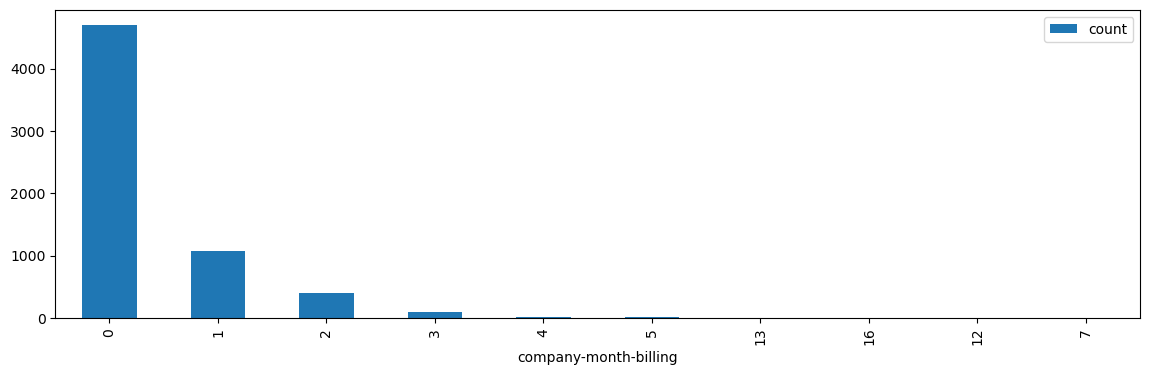

In [445]:
c_month_bil = activities['company-month-billing'].value_counts().reset_index()
display(c_month_bil)
c_month_bil.plot.bar( x='company-month-billing', figsize=(14,4))

### Вывод:
В основном компании не выставляют счета, или выставляют 1-2 за месяц.

,company-month-backups,count
0,0,5123
1,1,244
2,11,217
3,4,161
4,2,121
5,10,109
6,5,90
7,7,42
8,3,39
9,9,35


<Axes: xlabel='company-month-backups'>

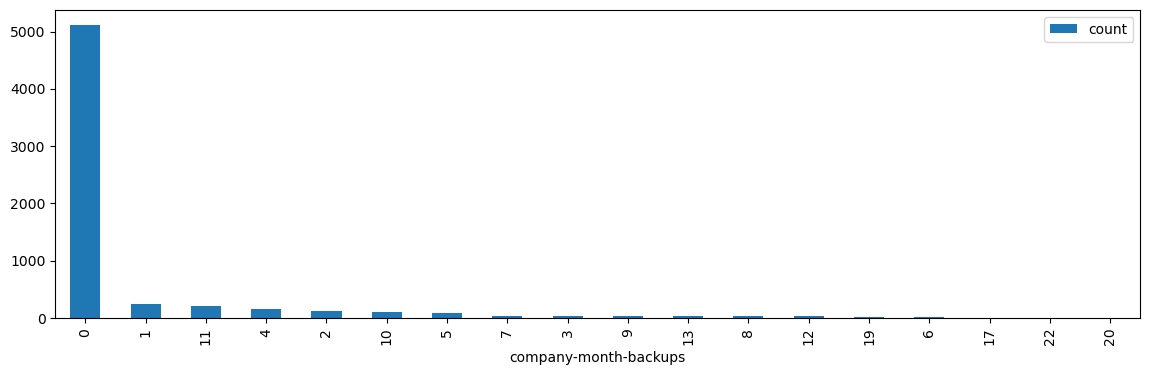

In [447]:
c_month_back = activities['company-month-backups'].value_counts().reset_index()
display(c_month_back)
c_month_back.plot.bar( x='company-month-backups', figsize=(14,4))

### Вывод: 
Компании практически не пользуются опцией backup. Необходимо уточнить у заказчика почему бэкапами занимаются сами клиенты, почему не реализовать автоматические бэкапы клиентов..

### Посмотрим на распределение следующих признаков:
 - 'company-month-stocks'
 - 'company-month-projects'
 - 'company-month-contractors'
 - 'company-month-resource_orders'

<Axes: >

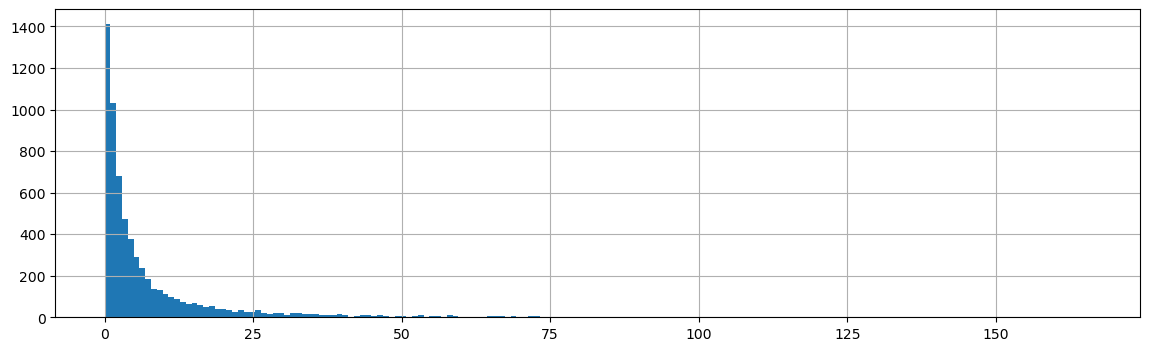

In [450]:
list_ = ['company-month-stocks', 'company-month-projects', 'company-month-contractors', 'company-month-resource_orders']

activities['company-month-stocks'].hist(bins=170, figsize=(14,4))

### Вывод: Много нулевых значений.

,company-month-projects,count
0,0,1314
1,1,1200
2,2,712
3,3,488
4,4,366
5,5,299
7,6,201
6,7,204
9,8,123
8,9,126


C:\Users\ns_77\AppData\Local\Temp\ipykernel_9044\4250904711.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticks(), fontsize=12)


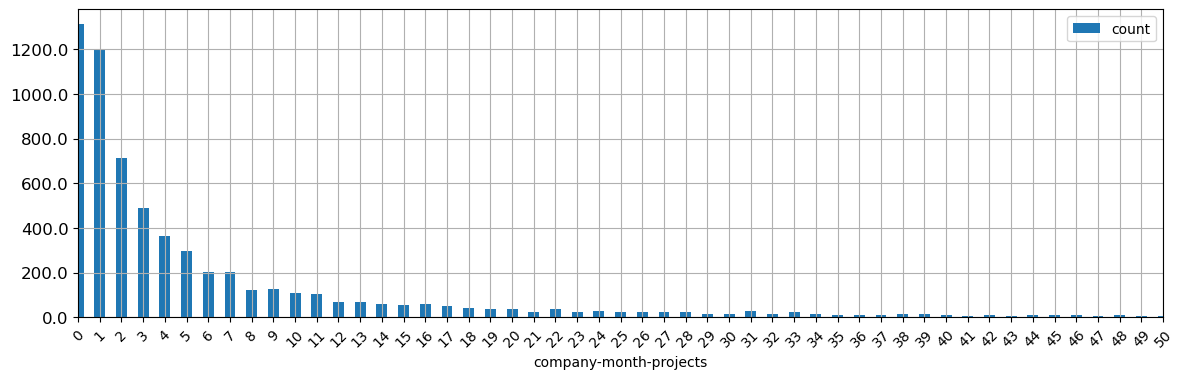

In [452]:
# Столбчатая диаграмма для company-month-projects:
r = activities['company-month-projects'].value_counts().reset_index().sort_values(by='company-month-projects')
fig, ax = plt.subplots(figsize=(14, 4))
display(r[0:10])
r.plot.bar(x='company-month-projects', y='count',ax=ax, rot=45, grid=True)
plt.xlim(0,50)

# Или ax1.set_ylim(0,180)

ax.set_yticklabels(ax.get_yticks(), fontsize=12)

plt.show()

,company-month-contractors,count
0,0,2061
1,1,849
2,2,664
3,3,403
4,4,297
5,5,261
6,6,170
7,7,156
8,8,135
9,9,106


C:\Users\ns_77\AppData\Local\Temp\ipykernel_9044\3553731627.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticks(), fontsize=12)


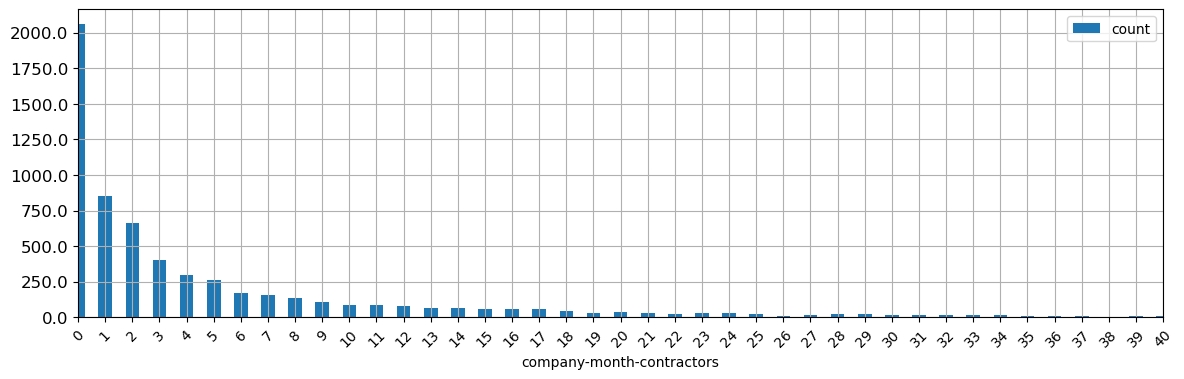

In [453]:
# Столбчатая диаграмма для company-month-contractors:
r = activities['company-month-contractors'].value_counts().reset_index().sort_values(by='company-month-contractors')
fig, ax = plt.subplots(figsize=(14, 4))
display(r[0:10])
r.plot.bar(x='company-month-contractors', y='count',ax=ax, rot=45, grid=True)
plt.xlim(0,40)

ax.set_yticklabels(ax.get_yticks(), fontsize=12)
plt.show()

### Вывод: 
В основном компании фиксируют от 1 до 15-17 контрагентов в месяц.

(-2.0, 20.0)

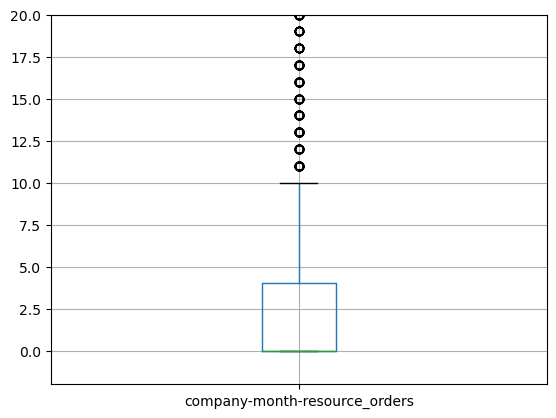

In [455]:
# Построим boxplot для company-month-resource_orders:

activities.boxplot('company-month-resource_orders')
plt.ylim(-2,20)

### Вывод:
За исследуемый период времени компании по месяцам зафиксировали(отметили) почти 4000 нулевых значений - месячного количества заказов материалов.

### Построим диаграмму распределения этого параметра ограничив значения по осям x и y.

,company-month-resource_orders,count
0,0,3905
1,1,328
2,5,246
3,3,211
4,2,210
...,...,...
153,165,1
152,233,1
151,67,1
150,121,1


C:\Users\ns_77\AppData\Local\Temp\ipykernel_9044\181281004.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticks(), fontsize=12)


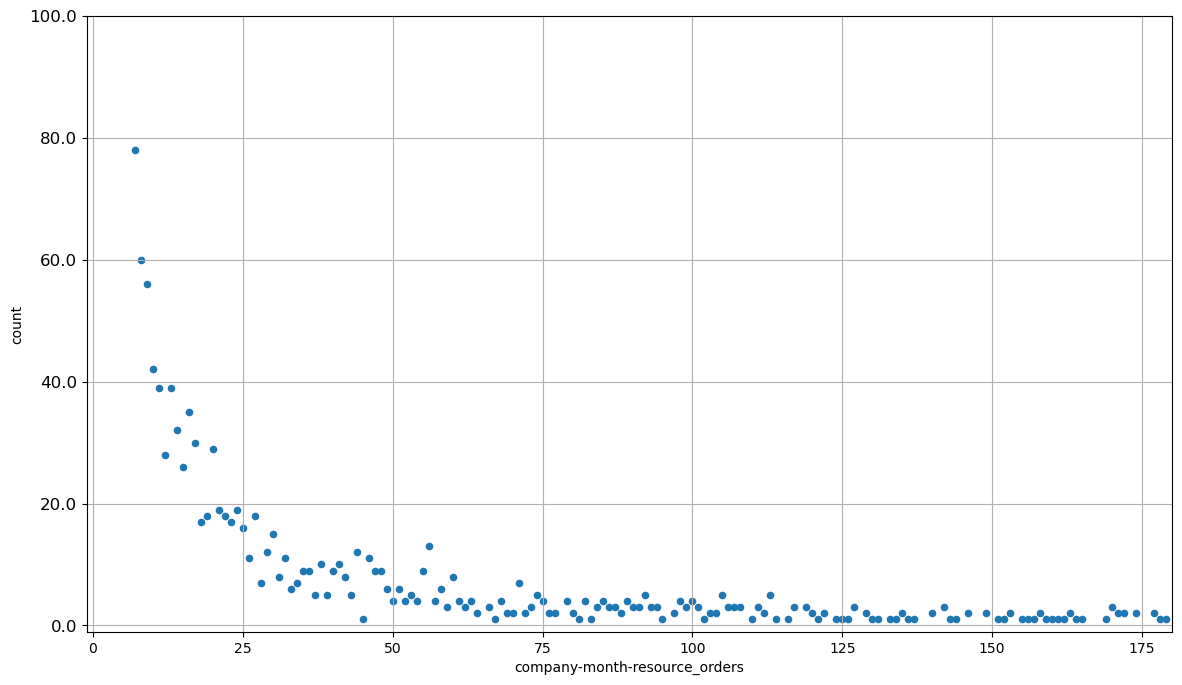

In [458]:
# Диаграмма рассеяния для company-month-resource_orders:
r = activities['company-month-resource_orders'].value_counts().reset_index().sort_values(by='count', ascending=False)
fig, ax = plt.subplots(figsize=(14, 8))
display(r)
r.plot.scatter(x='company-month-resource_orders', y='count',ax=ax, rot=0, grid=True)
plt.xlim(-1, 180)
plt.ylim(-1, 100)

ax.set_yticklabels(ax.get_yticks(), fontsize=12)
plt.show()

### Вывод: 
В основном у компаний которые вносят число заказов материалов отличных от 0, от 20 до 125 заказов материалов в месяц.

### Выведем диграммы рассеивания по всем параметрам:

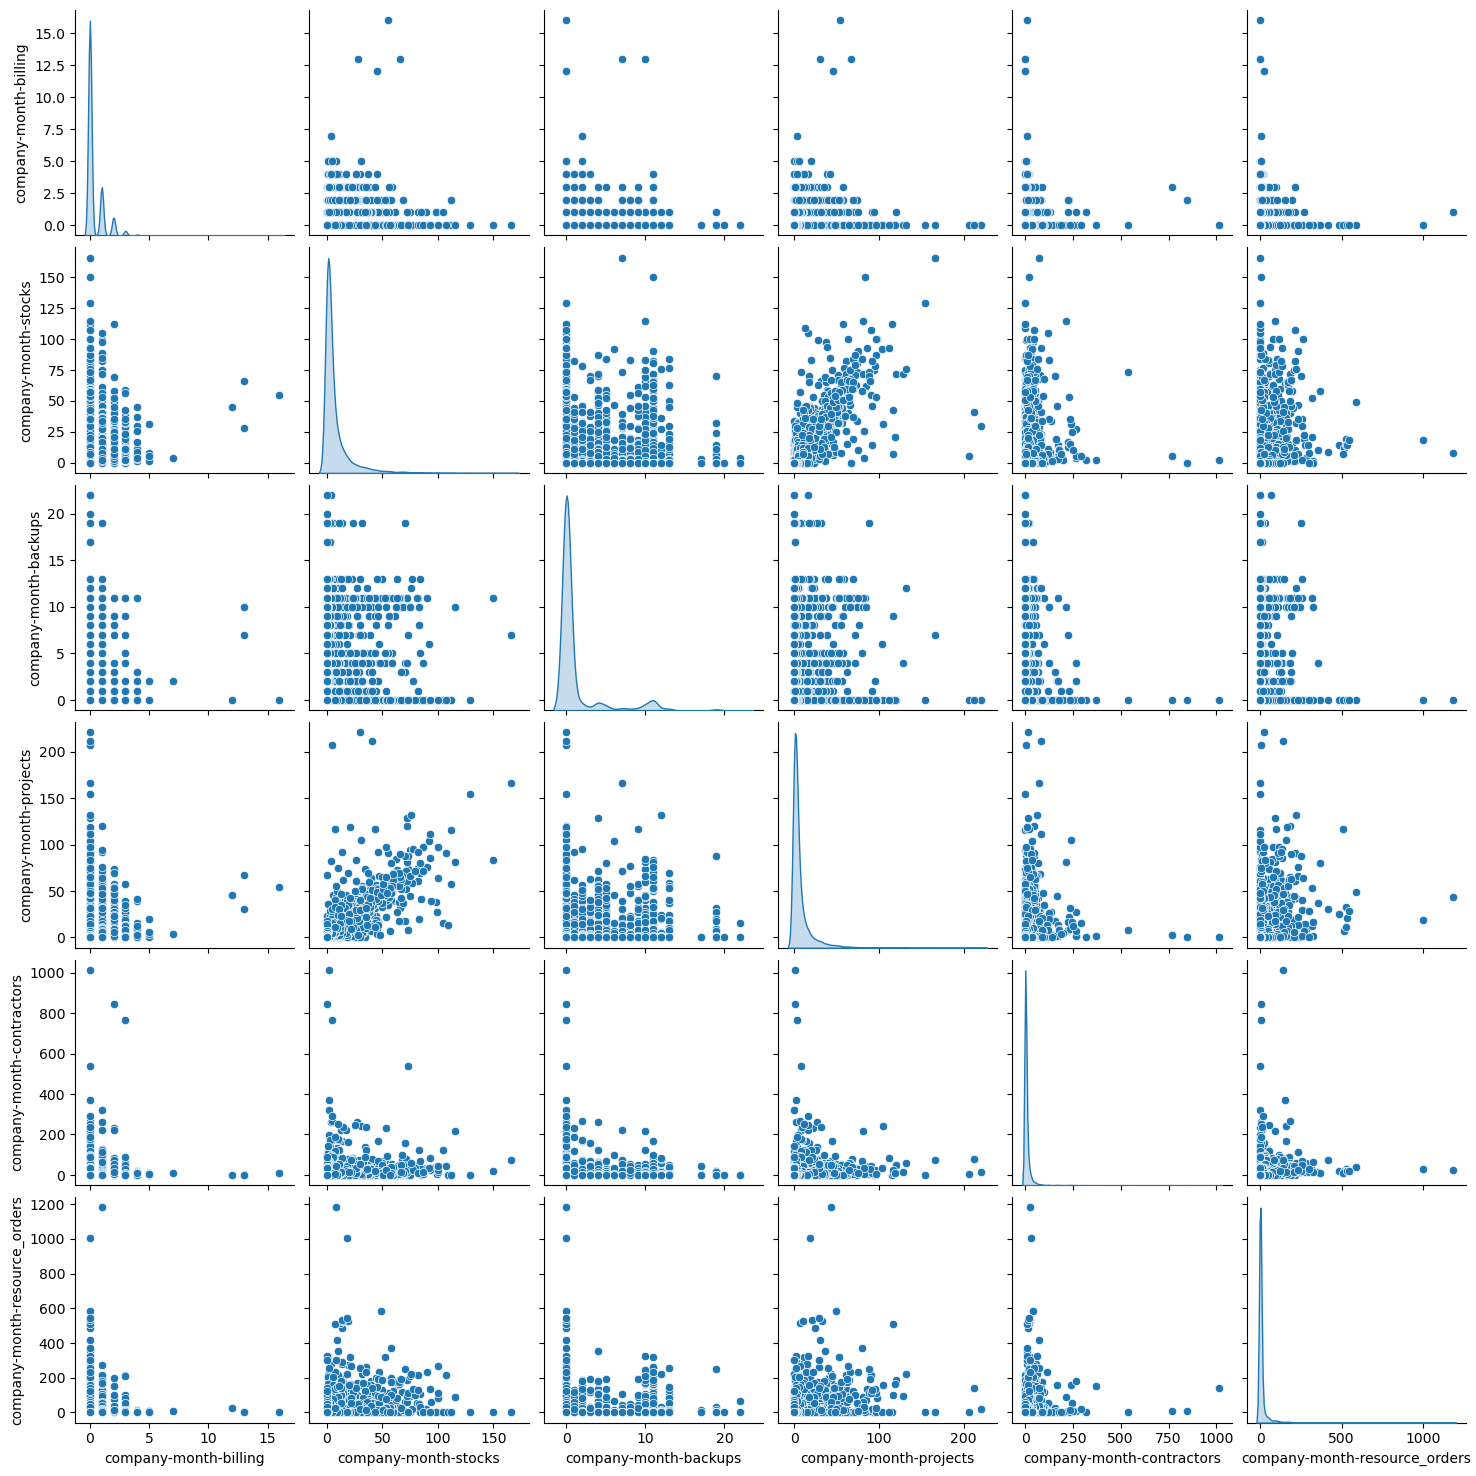

In [461]:
# Диаграммы рассеивания:

sns.pairplot(activities[['company-month-billing', 'company-month-stocks', 'company-month-backups', 'company-month-projects', 'company-month-contractors', 'company-month-resource_orders']], diag_kind='kde')
plt.show()

### Вывод: Выявленна положительная линейная связь между признаками: company-month-stocks и company-month-projects. Так же присутствуют выбросы на некоторых диаграммах.

### Выведем матрицу корреляции и изобразим ее в виде тепловой карты:

In [464]:
# Матрица корреляции: spearman (pearson, kendall) :

cor_matr = activities.corr(method = 'spearman', numeric_only=True)
cor_matr

,company_id,company-month-billing,company-month-stocks,company-month-backups,company-month-projects,company-month-contractors,company-month-resource_orders
company_id,1.000000,-0.069006,0.016809,-0.053500,0.001520,0.093517,0.300095
company-month-billing,-0.069006,1.000000,-0.032914,-0.153898,-0.095319,0.009848,-0.010610
company-month-stocks,0.016809,-0.032914,1.000000,-0.062018,0.841379,0.469007,0.227245
company-month-backups,-0.053500,-0.153898,-0.062018,1.000000,-0.056809,-0.048626,0.012700
company-month-projects,0.001520,-0.095319,0.841379,-0.056809,1.000000,0.406849,0.212868
company-month-contractors,0.093517,0.009848,0.469007,-0.048626,0.406849,1.000000,0.479675
company-month-resource_orders,0.300095,-0.010610,0.227245,0.012700,0.212868,0.479675,1.000000


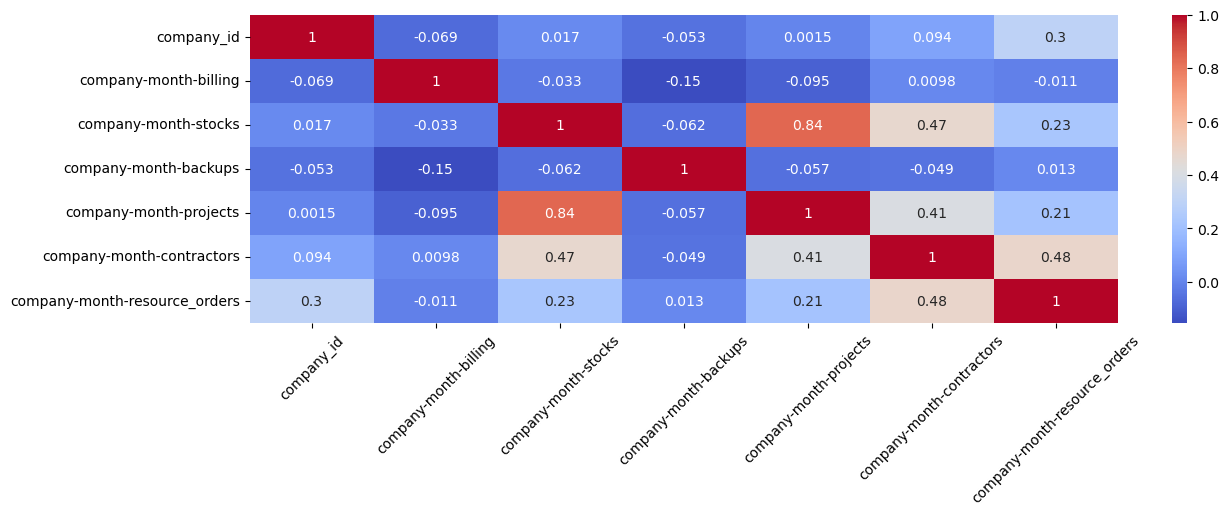

In [465]:
plt.figure(figsize=(14,4))
sns.heatmap(cor_matr, annot=True, cmap = 'coolwarm')
plt.xticks(rotation=45)
plt.show()

### Вывод: Есть положительная связь 0,84 между признаками company-month-stocks и company-month-projects.

#### Посмотрим как меняется во времени число компаний по числу выставленных счетов за месяц.

In [468]:
# Создадим сводную таблицу месяц и число - выставленных счетов - company-month-billing:
activities_ = activities.copy()
activities_.sort_values(by='month_', ascending=True, inplace=True)

# Сводная таблица:
pivot_ = activities_.pivot_table(index='month_', columns='company-month-billing', values='company_id', aggfunc='count')#.reset_index()
display(pivot_)

# Так же рассчитаем число компаний, которые выставляли счета в расчетном месяце:
total_company_month=activities.groupby('month_')['company_id'].count().reset_index()
display(total_company_month)

company-month-billing,0,1,2,3,4,5,7,12,13,16
month_,,,,,,,,,,
2019-01-01,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-02-01,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-03-01,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-04-01,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-05-01,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2023-11-01,148.0,17.0,8.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN
2023-12-01,122.0,25.0,3.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN
2024-01-01,120.0,21.0,7.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN


,month_,company_id
0,2019-01-01,2
1,2019-02-01,2
2,2019-03-01,1
3,2019-04-01,1
4,2019-05-01,9
...,...,...
58,2023-11-01,175
59,2023-12-01,151
60,2024-01-01,150
61,2024-02-01,149


### Построим соответствующие графики:

<Axes: xlabel='month_'>

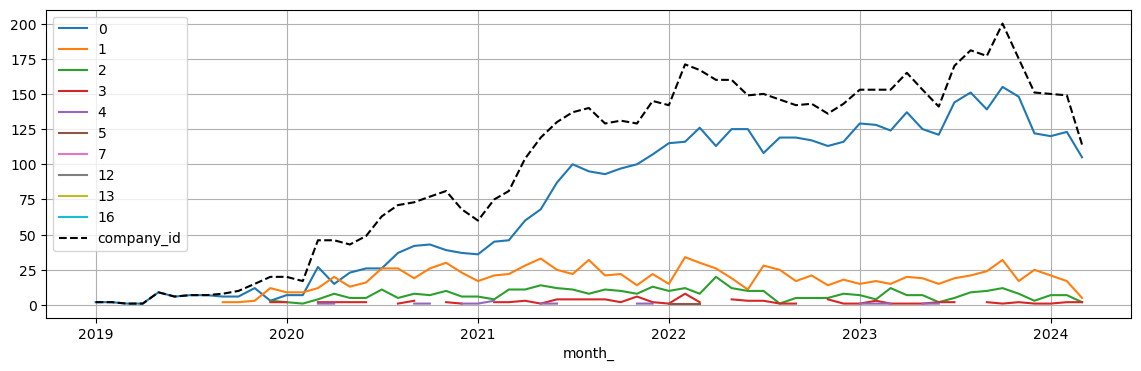

In [470]:
fig, ax1 = plt.subplots(figsize=(14, 8))
for col in pivot_.columns:
    # или - ax=plt.gca()
    pivot_.plot.line(y=col, figsize=(14,4), ax=ax1)
    
total_company_month.plot.line(x='month_', y='company_id', ax=ax1, color='black', grid=True, linestyle='dashed')

### Вывод: 
С ростом числа компаний, растет только число компаний выставивших - 0 счетов.

## Billing

In [473]:
billing.info()
billing[0:2]

<class 'pandas.core.frame.DataFrame'>
Index: 3479 entries, 4 to 18953
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   id                       3479 non-null   int64         
 1   user_id                  3479 non-null   int64         
 2   company_id               3479 non-null   int64         
 3   billing_tariff_id        3479 non-null   int64         
 4   payed_until              3479 non-null   datetime64[ns]
 5   is_payed                 3479 non-null   bool          
 6   created_at               3479 non-null   datetime64[ns]
 7   updated_at               3479 non-null   datetime64[ns]
 8   billing_tariff_price_id  3479 non-null   int32         
 9   comment                  745 non-null    object        
 10  pay_date                 1108 non-null   datetime64[ns]
 11  tariff_name              3479 non-null   object        
 12  tariff                   3479 non-null

,id,user_id,company_id,billing_tariff_id,payed_until,is_payed,created_at,updated_at,billing_tariff_price_id,comment,pay_date,tariff_name,tariff
4,3050,567,512,3,2021-12-22 06:08:22,False,2020-12-22 06:08:22,2020-12-22 06:08:22,12,NaN,NaT,профи,профи
6,3051,2861,2474,7,2021-12-22 00:00:00,True,2020-12-22 08:36:02,2020-12-22 08:36:21,23,NaN,2020-12-22 08:36:21,старт,старт


In [474]:
#Проверим как соотносятся user_id и company_id:
r = billing.groupby('user_id')['company_id'].unique().reset_index()
display(r[0:4])
filtered_r = r[r['company_id'].str.len() > 1]
filtered_r

,user_id,company_id
0,1,[1]
1,6,[5]
2,7,[6]
3,12,[11]


,user_id,company_id


### Вывод: 
Одному пользователю соответствует одна компания.

### Попробуем описать выставление счета в таблице billing:
Каждая строка - это счет выставленные Gectaro в адррес компании клиента, строка(выставление счета) имеет дату создания - created_at. А така же дату - payed_until - до которой действует тариф.



In [477]:
# Проверим как соотносятся атрибуты - is_payed и pay_date:
t = billing.pivot_table(index='is_payed', values='pay_date', aggfunc={'pay_date':[lambda x: x.count(), lambda x: x.isna().sum()]}).reset_index()

t = t.rename(columns={'<lambda_0>': 'pay_date_count', '<lambda_1>':'pay_date_nan'})
t

,is_payed,pay_date_count,pay_date_nan
0,False,237,2126
1,True,871,245


### Вывод: 
В обоих статусах столбца is_payed даты оплаты присутствуют так и отсутствуют, эти два столбца для определения целевой переменной использовать нельзя.

### Посмотрим сводную информацию по счетов по каким тарифам выставлялось больше:

In [480]:
tb = billing.groupby('tariff_name', as_index=False)['id'].count().sort_values(by='id', ascending=False).rename(columns={'id':'count_id'})
display(tb)
#Добавим в таблицу суммирующую строку и столбцец с процентами:
#total = tb['count_id'].sum()
tb['_%_'] = tb['count_id']*100/total

tb.loc['total'] = tb[['count_id', '_%_']].sum()

# Доп. вариант: #tb.loc['total'] = tb.sum(axis=0)

tb

,tariff_name,count_id
1,базовый,1573
4,старт,1416
2,бизнес,279
3,профи,194
0,no_tarif_name,17


,tariff_name,count_id,_%_
1,базовый,1573.0,45.214142
4,старт,1416.0,40.701351
2,бизнес,279.0,8.019546
3,профи,194.0,5.576315
0,no_tarif_name,17.0,0.488646
total,NaN,3479.0,100.000000


### Вывод:
45% выставленных счетов приходится на базовый тариф.

### Выявим целевую переменную - статус показателя - клиентская компания ушла и перестала пользоваться сервисом.

In [483]:
# Введем переменную даты 28.03.2024:
day_of_28 = pd.to_datetime('2024-03-28')
day_of_28

Timestamp('2024-03-28 00:00:00')

In [484]:
# Описание целевой переменной: Метод расчета основан на требованиях заказчика -
# Самое позднее значение для payed_until для компании сравнивается с датой: day_of_28 и если payed_until больше,
# чем дата (day_of_28) - компания может считаться действующим клиентом. В противном случае - компания
# считается ушедшей по непродлению оплаты.

# 0 - остался, 1 - ушел 

billing['gone_status'] = billing['payed_until'].apply(lambda x: 1 if x < day_of_28 else 0)

In [485]:
billing[billing['company_id'] == 512]

,id,user_id,company_id,billing_tariff_id,payed_until,is_payed,created_at,updated_at,billing_tariff_price_id,comment,pay_date,tariff_name,tariff,gone_status
4,3050,567,512,3,2021-12-22 06:08:22,False,2020-12-22 06:08:22,2020-12-22 06:08:22,12,NaN,NaT,профи,профи,1
204,3045,567,512,2,2026-01-05 23:59:59,False,2020-12-21 14:47:22,2020-12-21 14:47:22,1,NaN,NaT,базовый,базовый,0
264,3046,567,512,6,2021-06-21 14:55:39,False,2020-12-21 14:55:39,2020-12-21 14:55:39,17,NaN,NaT,no_tarif_name,архивный,1
346,3047,567,512,7,2033-04-10 23:59:59,False,2020-12-21 15:05:06,2020-12-21 15:05:06,23,NaN,NaT,старт,старт,0
1833,4063,567,512,2,2026-12-05 23:59:59,False,2021-05-11 07:32:19,2021-05-11 07:32:19,8,NaN,NaT,базовый,базовый,0
3211,856,567,512,4,2020-04-30 00:00:00,True,2020-01-30 07:23:37,2020-01-30 07:24:15,14,NaN,NaT,старт,старт,1
3380,938,567,512,2,2023-01-26 00:00:00,True,2020-03-04 12:49:11,2023-01-26 15:18:59,1,NaN,NaT,базовый,базовый,1


### Посмотрим как распределились платежи billings по целевой переменной:

In [487]:
billing['gone_status'].value_counts().reset_index()

,gone_status,count
0,1,2777
1,0,702


### Вывод:
Большая часть клиентов перестала пользоваться сервисом.

### People.

### Проверим есть ли компании, в которых работали несколько ответственных за работу в сервисе Gectaro сотрудников.

In [491]:
people[0:2]

,id,company_id,user_id,company_invite_id,role_id,created_at,updated_at,is_deleted,deleted_at
0,6601,495,999999,410,7133,2019-10-08 11:59:22,2019-10-08 11:59:22,True,2020-07-06 20:19:28
1,7025,1,999999,843,1,2020-07-07 11:14:44,2020-07-07 11:14:44,True,2020-07-07 11:14:48


In [492]:
r = people.groupby('company_id')['user_id'].unique().reset_index()
r['user_count'] = r['user_id'].str.len()
r.sort_values(by='user_count', ascending=True)

,company_id,user_id,user_count
223,3064,[3652],1
301,3668,[4509],1
662,8727,[11780],1
496,6110,[7942],1
172,2459,[2834],1
...,...,...,...
282,3524,"[4308, 4289, 4310, 999999, 4292, 4397, 4422, 4432, 4439, 4443, 4436, 4435, 4434, 4421, 4561, 4504, 4536, 4668, 5028, 5092, 5267, 5259, 5329, 5500, 5534, 5531, 5648, 5615, 5705, 5687, 5989, 4560, 4437]",33
307,3705,"[4555, 4556, 4775, 4776, 4760, 999999, 4791, 4780, 4874, 5168, 4793, 4789, 4792, 5159, 4790, 4881, 5169, 5075, 5142, 5158, 5188, 5206, 5151, 5675, 5759, 5688, 5976, 5741, 5708, 5325, 5165, 5109, 4937, 5093, 4883, 4777, 4774]",37
543,6806,"[8945, 5474, 999999, 8994, 8951, 8958, 7222, 8956, 8996, 8792, 9002, 9018, 9019, 9024, 9026, 8980, 8993, 9012, 9027, 9005, 9040, 9113, 9114, 9116, 9140, 9143, 9146, 9175, 9178, 9206, 9166, 9260, 9294, 9271, 9301, 9479, 10266, 10372, 8316]",39
280,3518,"[4279, 4302, 4294, 4328, 999999, 4354, 4399, 4401, 4717, 5145, 5390, 5614, 5410, 5597, 5723, 5711, 5873, 6056, 5243, 4304, 6982, 7116, 7574, 7981, 8037, 893, 8621, 8837, 8836, 8969, 9053, 10120, 11368, 9697, 11406, 11705, 9973, 12545, 12838, 12904, 12992]",41


<Axes: xlabel='user_count'>

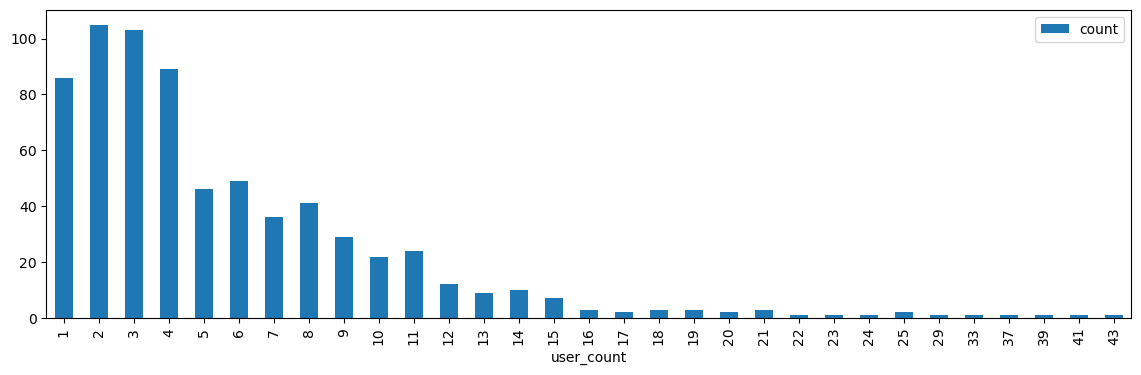

In [493]:
r['user_count'].value_counts().reset_index().sort_values(by='user_count').plot.bar(x='user_count', y ='count', figsize=(14,4))

### Вывод: 
Есть множество компаний, в которых работало с сервисом несколько, а иногда и десятки сотрудников(33, 37, 39, 41, 43). Сообщить заказчику о том что множество сотрудников имеет доступ к сервису. Столбец role_id для включения в анализ не подходит. Можем включить этот показатель в качестве дополнительного параметра, влияющего на отток клиентов.

### Проверим может ли у сотрудника быть несколько роллей(role_id)

In [496]:
people_role = people.groupby('user_id', as_index=False)['role_id'].count().sort_values(by='role_id', ascending=False)

# Посчитаем число сотрудников у которых больше двух ролей:
len(people_role[people_role['role_id'] > 2])

46

### Вывод: 
Число сотрудников с более чем двумя ролями 46, role_id не будем использовать в качестве параметра влияющего на отток клиентов.

# 3. Проверка гипотез и поиск признаков оттока.

### 3.1 Портрет пользователя 

Определите портрет наиболее массовой компании-пользователя. Сколько в ней сотрудников? Давно ли она пользуется сервисом? Стабильно ли платит? Давно ли были какие-то обновления в сервисе по компании? Каким тарифом пользуется? Чем объясняется именно такой портрет клиента? 

### Определите портрет наиболее массовой компании-пользователя. Сколько в ней сотрудников?

In [582]:
# Соединение таблиц: billing и companies:
billing_company = billing.merge(companies, left_on='company_id', right_on='id', how='left')
billing_company[0:3]

,id_x,user_id,company_id,billing_tariff_id_x,payed_until,is_payed,created_at_x,updated_at_x,billing_tariff_price_id,comment,pay_date,tariff_name_x,tariff,gone_status,id_y,working_direction,employer_count_interval,created_at_y,updated_at_y,billing_tariff_id_y,billing_is_over,tariff_name_y,number_employees,number_employees_
0,3050,567,512,3,2021-12-22 06:08:22,False,2020-12-22 06:08:22,2020-12-22 06:08:22,12,NaN,NaT,профи,профи,1,512.0,пропуски_,1.0,2019-10-17 06:41:18,2023-01-26 22:00:01,2.0,True,базовый,"[1, 4]","[1.0, 4.0]"
1,3051,2861,2474,7,2021-12-22 00:00:00,True,2020-12-22 08:36:02,2020-12-22 08:36:21,23,NaN,2020-12-22 08:36:21,старт,старт,1,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN
2,3059,1902,1645,2,2021-03-24 09:18:04,False,2020-12-24 09:18:04,2020-12-24 09:18:04,6,NaN,NaT,базовый,базовый,1,1645.0,пропуски_,1.0,2020-08-18 13:16:41,2023-04-30 22:00:02,2.0,True,базовый,"[1, 4]","[1.0, 4.0]"


In [221]:
# Посмотрим на то сколько в компаниях сотрудников:
billing_company.groupby('number_employees_', as_index=False)['company_id'].unique().sort_values(by='number_employees_')

,number_employees_,company_id
0,"[1.0, 4.0]","[512, 1645, 2035, 926, 2014, 2353, 366, 2565, 981, 2507, 4038, 3917, 3323, 21, 1975, 2227, 3410, 3495, 2263, 3457, 3958, 3907, 1737, 1265, 2774, 3865, 2620, 1935, 2635, 2543, 2484, 3596, 882, 1451, 628, 30, 2567, 1744, 2670, 2594, 309, 2547, 2755, 2590, 1970, 3717, 3231, 2753, 2771, 2213, 2383, 2800, 2767, 2226, 1277, 3640, 3664, 3521, 3635, 3115, 3885, 924, 2851, 3665, 3674, 3668, 3589, 1634, 921, 2409, 3112, 116, 2444, 2282, 2948, 2919, 3344, 3099, 3694, 3684, 2988, 575, 2493, 2431, 4100, 3471, 2704, 2161, 3031, 3085, 943, 3733, 2956, 3064, 3096, 3132, 2918, 3067, 3563, 3120, ...]"
1,"[5.0, 10.0]","[483, 3633, 3277, 2766, 3263, 3252, 1723, 3851, 2033, 2618, 2631, 3597, 2820, 3645, 2174, 2824, 344, 3654, 2966, 1339, 2002, 1642, 1640, 3078, 2998, 3745, 3742, 3079, 3178, 3239, 3307, 3456, 3327, 749, 541, 218, 430, 3953, 738, 108, 919, 1071, 1569, 1787, 720, 4199, 4200, 2833, 2128, 4430, 4669, 4608, 4668, 4598, 4644, 4736, 3696, 2838, 4817, 4902, 3932, 4824, 4566, 5120, 2866, 5176, 5927, 5119, 5254, 5144, 5318, 4072, 3502, 5389, 4278, 3611, 5560, 4894, 3499, 5591, 5758, 5770, 2791, 5916, 3009, 5416, 5961, 5986, 5381, 6527, 6004, 4042, 6113, 5790, 6124, 6080, 5820, 5817, 6341, 6086, ...]"
2,"[11.0, 20.0]","[2265, 3855, 3828, 3494, 1255, 2897, 2391, 3921, 1492, 1, 257, 667, 1154, 4334, 4517, 4585, 4480, 4794, 2560, 5225, 5005, 5445, 5646, 5742, 4906, 5896, 5183, 5322, 6179, 6293, 6279, 6141, 7000, 6989, 7158, 7329, 3680, 8862, 8789, 8968, 4320, 3623, 8437, 3158, 9815, 9742]"
3,"[21.0, 30.0]","[3524, 2626, 2731, 1846, 4086, 3705, 421, 650, 1067, 4580, 6805, 7591, 8180, 9457]"
4,"[31.0, 50.0]","[1210, 4479, 4611, 5423, 6342, 7211, 7321, 7423, 3978]"
5,"[51.0, 100.0]","[5441, 6305]"
6,"[101.0, 200.0]","[5865, 7260, 8900]"
7,"[200.0, 300.0]","[3224, 2348, 3464, 6712]"


### Вывод:
 - Самыми крупными компаниями по числу сотрудников являются - 3224, 2348, 3464, 6712, в каждой более 200 человек.

### Выясним - Давно ли эти компании пользуются сервисом?

In [222]:
billing_company[billing_company['company_id']== 6712]

,id_x,user_id,company_id,billing_tariff_id_x,payed_until,is_payed,created_at_x,updated_at_x,billing_tariff_price_id,comment,pay_date,tariff_name_x,tariff,gone_status,id_y,working_direction,employer_count_interval,created_at_y,updated_at_y,billing_tariff_id_y,billing_is_over,tariff_name_y,number_employees,number_employees_
2619,9495,8804,6712,10,2024-04-17,False,2022-10-17 09:48:56,2022-10-17 09:49:00,33,NaN,NaT,профи,профи,0,6712.0,строительство,8.0,2022-09-20 13:00:46,2023-01-12 22:00:02,13.0,False,профи,"[200, 300]","[200.0, 300.0]"
2715,9835,8804,6712,13,2023-01-12,True,2022-12-19 08:50:30,2023-01-12 14:37:27,43,"До этого был Профи.\r\nДали доступ к сводному графику\r\n12.01.23 - осталось 567 дней (до 01,08,2024) - временно заморозили, пока не реализуется запрос по доработке снабжения)",2022-12-19,профи,профи,1,6712.0,строительство,8.0,2022-09-20 13:00:46,2023-01-12 22:00:02,13.0,False,профи,"[200, 300]","[200.0, 300.0]"
3095,9575,8804,6712,10,2025-02-19,True,2022-10-31 09:21:01,2023-08-11 10:16:47,33,"1,12,22 запросили активацию тарифа 18+2\r\n12.01.23 - осталось 567 дней (до 01,08,2024) - временно заморозили, пока не реализуется запрос по доработке снабжения)\r\n31,01,23 Приняли решение разморозить, но количество дней будет идти с того момента, как мы сделаем доработки им, т.е. потом еще раз добавить дни\r\n11,08 отправили им письмо, что последняя их доработка была реализована 19,06,23 и с этого времени их весь тариф будет идти 18+2",2022-12-01,профи,профи,0,6712.0,строительство,8.0,2022-09-20 13:00:46,2023-01-12 22:00:02,13.0,False,профи,"[200, 300]","[200.0, 300.0]"


In [595]:
time_to_using = billing_company[billing_company[ 'company_id'].isin([3224, 2348, 3464, 6712])]
display(time_to_using)
w = time_to_using.pivot_table(index='company_id', values=['payed_until', 'created_at_x'], aggfunc={'created_at_x':'min', 'payed_until':'max'}).reset_index()

# Добавим в таблицу число дней использования сервиса:
w['d'] = w['payed_until'] - w['created_at_x']
w

,id_x,user_id,company_id,billing_tariff_id_x,payed_until,is_payed,created_at_x,updated_at_x,billing_tariff_price_id,comment,pay_date,tariff_name_x,tariff,gone_status,id_y,working_direction,employer_count_interval,created_at_y,updated_at_y,billing_tariff_id_y,billing_is_over,tariff_name_y,number_employees,number_employees_
620,3991,3878,3224,9,2022-05-24 00:00:00,True,2021-04-30 16:14:42,2021-05-24 06:53:36,29,"24,05 пришла оплата",2021-05-04 00:00:00,бизнес,бизнес,1,3224.0,малоэтажное строительство,8.0,2021-04-29 11:57:33,2021-09-10 14:22:34,9.0,False,бизнес,"[200, 300]","[200.0, 300.0]"
1211,2959,2702,2348,3,2020-12-03 00:00:00,True,2020-12-02 12:47:16,2020-12-03 06:41:47,12,требуется активировать на другого сотрудника основной аккаунт,NaT,профи,профи,1,2348.0,пропуски_,8.0,2020-11-13 13:02:44,2022-12-06 03:44:48,3.0,True,профи,"[200, 300]","[200.0, 300.0]"
2327,8363,3878,3224,9,2023-05-17 00:00:00,False,2022-05-17 11:26:23,2022-05-17 11:26:26,29,NaN,NaT,бизнес,бизнес,1,3224.0,малоэтажное строительство,8.0,2021-04-29 11:57:33,2021-09-10 14:22:34,9.0,False,бизнес,"[200, 300]","[200.0, 300.0]"
2480,8429,3878,3224,9,2023-09-24 00:00:00,True,2022-05-23 07:57:26,2022-07-05 10:23:34,29,12+1\r\n05 07 2022 +3 месяца за кейс,2022-05-23 00:00:00,бизнес,бизнес,1,3224.0,малоэтажное строительство,8.0,2021-04-29 11:57:33,2021-09-10 14:22:34,9.0,False,бизнес,"[200, 300]","[200.0, 300.0]"
2490,8846,4198,3464,2,2023-07-08 11:00:50,False,2022-07-08 11:00:50,2022-07-08 11:00:50,8,NaN,NaT,базовый,базовый,1,3464.0,пропуски_,8.0,2021-05-30 08:53:17,2023-08-21 22:00:02,2.0,True,базовый,"[200, 300]","[200.0, 300.0]"
2491,8847,4198,3464,11,2023-01-08 00:00:00,False,2022-07-08 11:16:13,2022-07-08 11:16:19,38,NaN,NaT,старт,старт,1,3464.0,пропуски_,8.0,2021-05-30 08:53:17,2023-08-21 22:00:02,2.0,True,базовый,"[200, 300]","[200.0, 300.0]"
2492,8848,4198,3464,2,2022-07-15 00:00:00,False,2022-07-08 11:18:44,2022-07-08 11:19:25,8,NaN,2022-07-11 00:00:00,базовый,базовый,1,3464.0,пропуски_,8.0,2021-05-30 08:53:17,2023-08-21 22:00:02,2.0,True,базовый,"[200, 300]","[200.0, 300.0]"
2619,9495,8804,6712,10,2024-04-17 00:00:00,False,2022-10-17 09:48:56,2022-10-17 09:49:00,33,NaN,NaT,профи,профи,0,6712.0,строительство,8.0,2022-09-20 13:00:46,2023-01-12 22:00:02,13.0,False,профи,"[200, 300]","[200.0, 300.0]"
2715,9835,8804,6712,13,2023-01-12 00:00:00,True,2022-12-19 08:50:30,2023-01-12 14:37:27,43,"До этого был Профи.\r\nДали доступ к сводному графику\r\n12.01.23 - осталось 567 дней (до 01,08,2024) - временно заморозили, пока не реализуется запрос по доработке снабжения)",2022-12-19 00:00:00,профи,профи,1,6712.0,строительство,8.0,2022-09-20 13:00:46,2023-01-12 22:00:02,13.0,False,профи,"[200, 300]","[200.0, 300.0]"
2940,10868,4198,3464,10,2023-05-03 00:00:00,True,2023-05-03 09:29:43,2023-05-03 09:43:13,32,"03,05,23 - активация на 3 дня тарифа",2023-05-03 00:00:00,профи,профи,1,3464.0,пропуски_,8.0,2021-05-30 08:53:17,2023-08-21 22:00:02,2.0,True,базовый,"[200, 300]","[200.0, 300.0]"


,company_id,created_at_x,payed_until,d
0,2348,2020-12-02 12:47:16,2020-12-03,0 days 11:12:44
1,3224,2021-04-30 16:14:42,2024-11-24,1303 days 07:45:18
2,3464,2022-07-08 11:00:50,2023-08-21,408 days 12:59:10
3,6712,2022-10-17 09:48:56,2025-02-19,855 days 14:11:04


### Вывод: 
Наиболее долго 1303 дня из 4-х крупнейших компаний сервисом пользуется компания - 3224.

### 3.2 Проверка гипотез 

При ответе на приведенные ниже вопросы используйте не только качественные, но и количественные методы проверки статистических гипотез. Обосновывайте выбор статистических критериев. 

Есть ли какая-то связь между описанными выше признаками пользователя и целевой переменной: 

- есть ли зависимость уходов компаний от размера компании? 
- с каких тарифов уходят чаще (предположите, почему)? 
- обратите внимание, что тарифы с течением времени появляются, исчезают и изменяются, проследите динамику ухода с разных тарифов по годам. 
- посмотрите на поле billing_tariff_price_id (отражает изменение цены одного и того же тарифа). Влияет ли это поле на целевую переменную?  

In [602]:
# Выберем компании у которых дата выставления платежа(created_at) является самой поздней:

# Функция возвращает строку у которой created_at максимальный:
def g(df):
    return df.loc[df['created_at'].idxmax()]

r = billing.groupby('company_id', as_index=False).apply(g)
r[0:3]

C:\Users\ns_77\AppData\Local\Temp\ipykernel_9044\2484668540.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  r = billing.groupby('company_id', as_index=False).apply(g)


,id,user_id,company_id,billing_tariff_id,payed_until,is_payed,created_at,updated_at,billing_tariff_price_id,comment,pay_date,tariff_name,tariff,gone_status
0,1135,1,1,3,2021-07-25 23:59:59,False,2020-04-21 10:49:56,2020-04-21 10:49:56,12,NaN,NaT,профи,профи,1
1,10979,6,5,17,2024-11-19 00:00:00,True,2023-05-19 13:16:02,2023-05-19 13:16:22,25,NaN,2023-05-19 13:16:22,базовый,базовый,0
2,387,7,6,2,2019-10-25 23:59:59,False,2019-07-25 10:54:03,2019-07-25 10:54:03,6,NaN,NaT,базовый,базовый,1


### Подготовка таблиц для проверки стат гипотез:

In [612]:
# Соединим полученную таблицу r сгруппированную по компаниям и таблицу activities:
r1 = pd.merge(activities, r, left_on='company_id', right_on='company_id', how='left')
r1[0:3]

,company_id,month,company-month-billing,company-month-stocks,company-month-backups,company-month-projects,company-month-contractors,company-month-resource_orders,month_,id,user_id,billing_tariff_id,payed_until,is_payed,created_at,updated_at,billing_tariff_price_id,comment,pay_date,tariff_name,tariff,gone_status
0,1,2019-09-01 00:00:00+00:00,1,0,0,7,0,0,2019-09-01,1135,1,3,2021-07-25 23:59:59,False,2020-04-21 10:49:56,2020-04-21 10:49:56,12,NaN,NaT,профи,профи,1
1,1,2019-12-01 00:00:00+00:00,1,0,0,2,1,0,2019-12-01,1135,1,3,2021-07-25 23:59:59,False,2020-04-21 10:49:56,2020-04-21 10:49:56,12,NaN,NaT,профи,профи,1
2,1,2020-04-01 00:00:00+00:00,4,1,0,1,6,0,2020-04-01,1135,1,3,2021-07-25 23:59:59,False,2020-04-21 10:49:56,2020-04-21 10:49:56,12,NaN,NaT,профи,профи,1


In [614]:
# Распределение групп по статусу:
r1['gone_status'].value_counts().reset_index()

,gone_status,count
0,1,3651
1,0,2665


### Построим гистограммы и распределения признаков для тех, кто ушёл (отток) и тех, кто остался (не попали в отток)

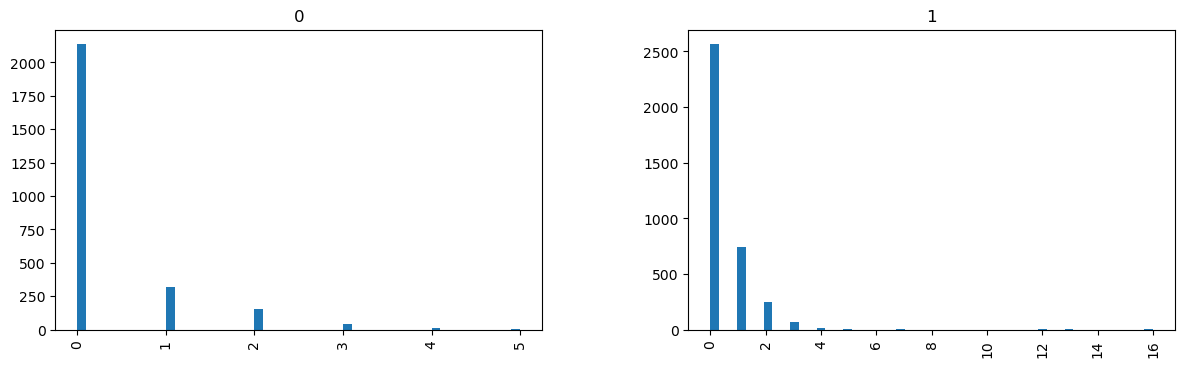

In [623]:
# Пример с .hist()
# Гистограммы:
r1.hist(column=['company-month-billing'], bins=50, by='gone_status', figsize=(14, 4))
plt.show()

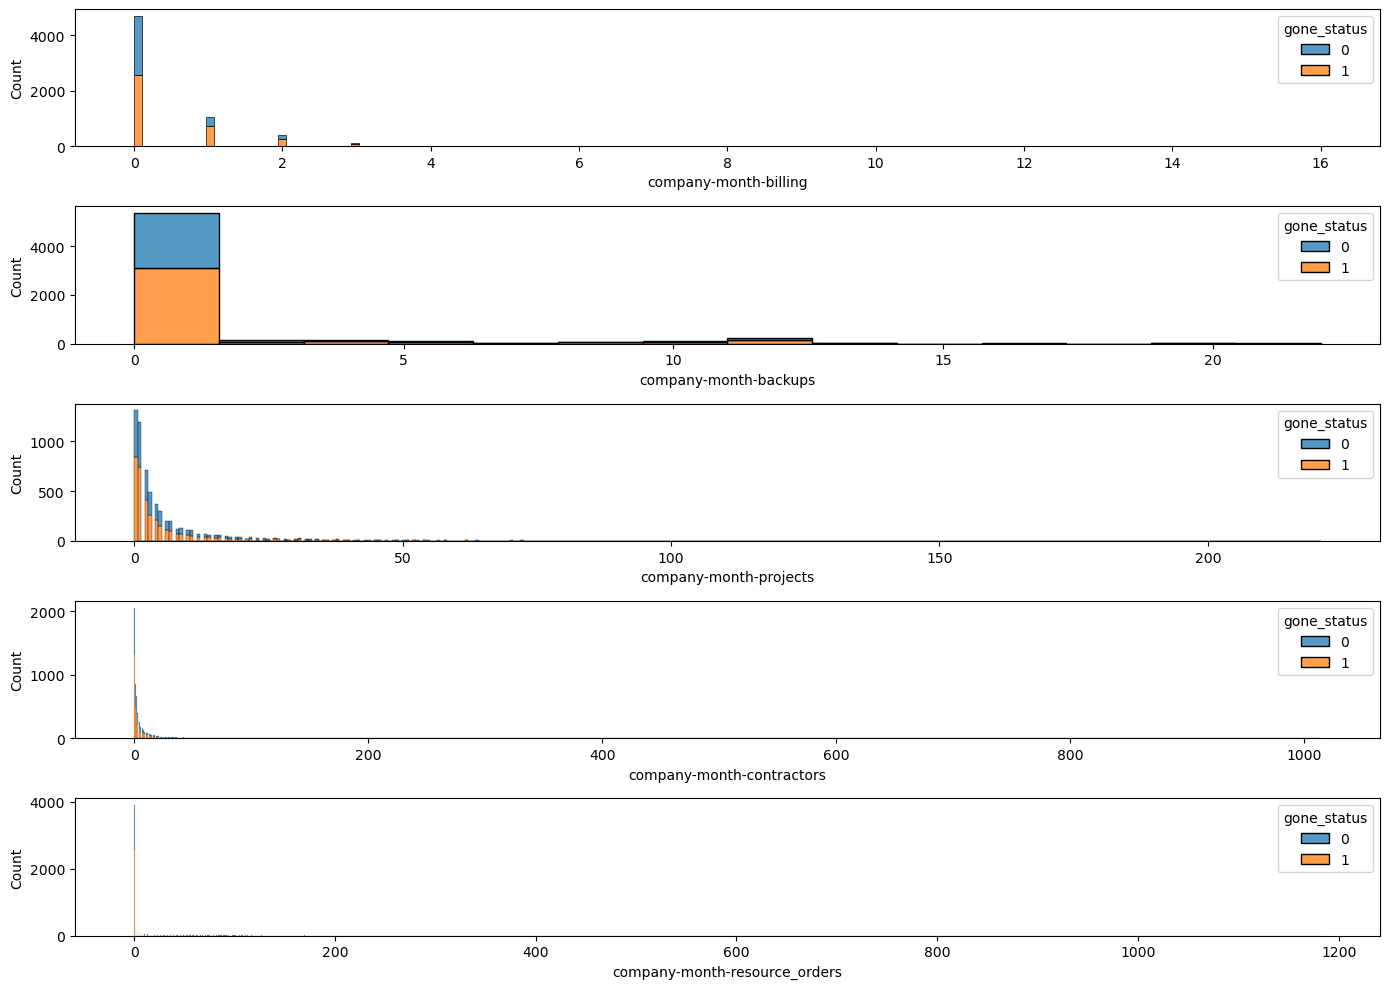

In [619]:
act_list = ['company-month-billing', 'company-month-backups', 'company-month-projects', 'company-month-contractors', 'company-month-resource_orders']

# Пример с sns.histplot()
fig = plt.figure(figsize=(14,10), constrained_layout=False)
i = 1

for act_col in act_list:
    ax = fig.add_subplot(5, 1, i)
    ax = sns.histplot(data=r1, x=act_col, hue='gone_status', multiple='stack')
    i += 1
    fig.tight_layout()

# sns.histplot(data= r1, x='company-month-billing', hue='gone_status', multiple='stack')

# fig, ax = plt.subplots(5, figsize=(14,5))

### Посмотрим на средние значения параметров по граппам в зависимости от статуса (gone_status):

In [625]:
table_relation = r1.groupby('gone_status', as_index=False)[['company-month-billing', 'company-month-backups', 'company-month-projects', 'company-month-contractors', 'company-month-resource_orders']].mean()

# Добавим строку отношение группы gone к группе stay:
table_relation.loc['relation'] = table_relation.iloc[0, 1:] / table_relation.iloc[1, 1:]
table_relation

,gone_status,company-month-billing,company-month-backups,company-month-projects,company-month-contractors,company-month-resource_orders
0,0.0,0.297561,1.214634,8.654034,10.618011,17.837523
1,1.0,0.431663,1.151739,6.247056,5.927143,4.877842
relation,NaN,0.689337,1.054609,1.385298,1.791421,3.656848


### Вывод: 
Средние значения признаков ушедших компаний составляют от 0,27 до 0,948 доли средних значений оставшихся. За исключением параметра company-month-billing - среднее ушедших выше чем у оставшихся в 1,45 раза.

## Построим модель прогнозирования ухода(оттока) компаний клиентов:

### Так как на тепловой карте (корреляция признаков таблицы activities)заметна очень сильная корреляция двух признаков: 'company-month-stocks' и company-month-projects', коэффициент корреляции = 0,84.  Одну переменную из пары мультиколлинеарных (сильно скоррелированных), стоит удалить, иначе она будет доминировать при обучении.

In [631]:
r2 = r1.copy()
r2.drop('company-month-stocks', axis = 1, inplace = True)

### Построим модель бинарной классификации компаний, где целевой признак — факт оттока компании.

#### Разделим данные на обучающую и валидационную выборку функцией train_test_split().

In [635]:
r2[0:2]

,company_id,month,company-month-billing,company-month-backups,company-month-projects,company-month-contractors,company-month-resource_orders,month_,id,user_id,billing_tariff_id,payed_until,is_payed,created_at,updated_at,billing_tariff_price_id,comment,pay_date,tariff_name,tariff,gone_status
0,1,2019-09-01 00:00:00+00:00,1,0,7,0,0,2019-09-01,1135,1,3,2021-07-25 23:59:59,False,2020-04-21 10:49:56,2020-04-21 10:49:56,12,NaN,NaT,профи,профи,1
1,1,2019-12-01 00:00:00+00:00,1,0,2,1,0,2019-12-01,1135,1,3,2021-07-25 23:59:59,False,2020-04-21 10:49:56,2020-04-21 10:49:56,12,NaN,NaT,профи,профи,1


In [637]:
# Отделим признаки от целевой переменной:
X = r2[['company-month-billing', 'company-month-backups', 'company-month-projects', 'company-month-contractors', 'company-month-resource_orders']]
y = r2['gone_status']

display(X.head(2))
display(y.head(2))

# Разделяем данные на обучающую и валидационную выборки в долях 0.8 на 0.2 соответственно:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y, random_state = 0)

,company-month-billing,company-month-backups,company-month-projects,company-month-contractors,company-month-resource_orders
0,1,0,7,0,0
1,1,0,2,1,0


0    1
1    1
Name: gone_status, dtype: int64

### Стандартизируем данные по всему набору признаков:

In [641]:
# Стандартизируем данные по всему набору признаков:
scaler = StandardScaler()

# Обучим и стандартизируем обучающую и валидационную выборки:
X_train_st = scaler.fit_transform(X_train)
X_test_st = scaler.fit_transform(X_test)

#### Обучим модель на train-выборке двумя способами:
- логистическая регрессия
- случайный лес

In [644]:
#Задаем алгоритм модели - логистическая регрессия:
# Присвоим модели алгоритм - LogisticRegression():
model = LogisticRegression(random_state = 0)

# или
# model = LogisticRegression(solver='liblinear')

# Обучаем модель:
model.fit(X_train_st, y_train)

# Рассчитываем прогноз целевой переменной:
log_regress_prediction = model.predict(X_test_st)

display(log_regress_prediction)

array([1, 0, 1, ..., 1, 1, 1], dtype=int64)

In [126]:
# Создадим датафрейм с признаками и их весами

coef = model.coef_.flatten().round(3)
display(coef)
features = pd.DataFrame({'feature':X_train.columns, 'coeff':coef})# воспользуйтесь методом coef_
display(features)

array([ 0.15 ,  0.042, -0.05 , -0.119, -0.236])

,feature,coeff
0,company-month-billing,0.150
1,company-month-backups,0.042
2,company-month-projects,-0.050
3,company-month-contractors,-0.119
4,company-month-resource_orders,-0.236


In [127]:
# Вывод:

#features['_%'] = features['coeff'].apply(lambda x: (math.exp(x)-1)*100)
features['_%'] = features['coeff'].apply(lambda x: (math.exp(x)))
features

,feature,coeff,_%
0,company-month-billing,0.150,1.161834
1,company-month-backups,0.042,1.042894
2,company-month-projects,-0.050,0.951229
3,company-month-contractors,-0.119,0.887808
4,company-month-resource_orders,-0.236,0.789781


### Вывод: 

Наибольшее влияние на принадлежность к классу(клиент ушел) оказывает параметр company-month-billing	0.150. При этом влияние не значительное. (Чем ближе коэфициент к нулю, тем мене он важен.)

#### Оценим метрики accuracy, precision и recall для обеих моделей на валидационной выборке. Сравним по ним модели. Выделим модель, которая показала себя лучше на основании метрик.

In [650]:
# Метрики accuracy, precision и recall для модели - логистической регрессии:
print("Метрики для модели - логистической регрессии:")
print('\tAccuracy: {:.2f}'.format(accuracy_score(y_test, log_regress_prediction)))
print('\tPrecision: {:.2f}'.format(precision_score(y_test, log_regress_prediction)))
print('\tRecall: {:.2f}'.format(recall_score(y_test, log_regress_prediction)))
print()

Метрики для модели - логистической регрессии:
	Accuracy: 0.61
	Precision: 0.61
	Recall: 0.95



 - Accuracy - показывает, какую долю всех образцов модель классифицировала верно. В данном случае, модель правильно классифицировала 61% всех образцов.
 - Precision (точность): отражает, какая доля образцов, классифицированных моделью как положительные, действительно являются положительными. Иными словами, из всех образцов, которые модель определила как принадлежащие к положительному классу, 61% действительно были положительными.
 - Recall (полнота): показывает, какую долю всех положительных образцов модель смогла обнаружить. То есть, из всех образцов, которые действительно принадлежали к положительному классу, модель нашла 95%

Модель демонстрирует высокую способность обнаруживать положительные образцы (высокий Recall). т.е. редко пропускает положительные случаи. При этом модель делает достаточно много ложных срабатываний, так как Precision относительно низкий, т.е. часто классифицирует отрицательные образцы как положительные.

In [655]:
# Задаем алгоритм модели - случайный лес:

# Параметры:
# число деревьев, на основании которых строиться лес - n_estimators
# глубина дерева - max_depth
# размер подвыборки признаков - max_features
# минимальное количество объектов в узле - min_samples_leaf

# Присвоим модели алгоритм - RandomForestClassifier(), т.к. решаем задачу классификации:
rand_forest_model = RandomForestClassifier(n_estimators = 100, random_state = 0)

# Обучаем модель:
rand_forest_model.fit(X_train_st, y_train)

# Рассчитываем прогноз целевой переменной:
rand_forest_prediction = rand_forest_model.predict(X_test_st)

# Вычисление вероятности определения оттока пользователей (0 или 1)
rand_forest_probabilities = rand_forest_model.predict_proba(X_test_st)[:,1]

#display(rand_forest_prediction)
#display(rand_forest_probabilities)

In [657]:
display(rand_forest_prediction)
display(rand_forest_probabilities)

array([0, 0, 1, ..., 1, 1, 0], dtype=int64)

array([0.44304053, 0.29      , 0.75373922, ..., 1.        , 0.56248257,
       0.45      ])

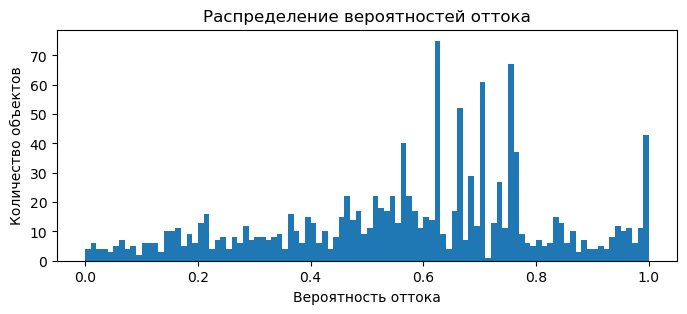

In [706]:
# Построим гистограмму вероятности оттока:

plt.figure(figsize=(8, 3))
plt.hist(rand_forest_probabilities, bins=100)
plt.xlabel('Вероятность оттока')
plt.ylabel('Количество объектов')
plt.title('Распределение вероятностей оттока')
plt.show()

### Посмотрим на матрицу ошибок: На сколько хорошо модель предсказывает как положительные так и отрицательные классы.

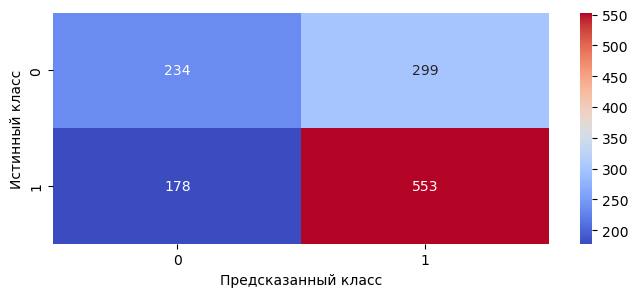

In [684]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 3))
cm = confusion_matrix(y_test, rand_forest_prediction)
sns.heatmap(cm, annot=True, fmt='d', cmap='coolwarm')
plt.xlabel('Предсказанный класс')
plt.ylabel('Истинный класс')
plt.show()

### Вывод: 
Модель хорошо предсказывает положительные результаты, правильно классифицировала более половины наблюдений.

### Критерий Хи-квадрат:

###  Выясним существует ли статистически значимая связь между двумя признаками(company-month-billing и gone_status) с помощьюстатистики Хи-квадрат. Составим таблицу сопряженности двух атрибутов.

### Формулируем гипотезы:
 - 𝐻0 Атрибуты: gone_status и company-month-billing - независимы.
 - H1 Атрибуты: gone_status и company-month-billing - зависимы.

In [689]:
# Таблица сопряженности:
cross_tab = pd.crosstab( r1['gone_status'], r1['company-month-billing'])
cross_tab[0:5]

company-month-billing,0,1,2,3,4,5,7,12,13,16
gone_status,,,,,,,,,,
0,2139,322,155,38,8,3,0,0,0,0
1,2569,745,249,65,13,5,1,1,2,1


In [691]:
# Применение теста Хи-квадрат:
chi2, p_value, _, _ = chi2_contingency(cross_tab)

display("Значение статистики Хи-квадрат:", chi2)
display("p-значение:", p_value)

alpha = 0.05

if (p_value < alpha):
    print("Отвергаем нулевую гипотезу")
else: print("Не получилось отвергнуть нулевую гипотезу")

'Значение статистики Хи-квадрат:'

90.89584434464496

'p-значение:'

1.076105652327534e-15

Отвергаем нулевую гипотезу


### Вывод:
𝐻0 отвергаем на уровне значимости 𝛼, на имеющихся данных. Это означает, что с очень высокой вероятностью можем утверждать, что между признаками company-month-billing и gone_status существует статистически значимая зависимость.
 - Значение статистики Хи-квадрат: 90.89 - велико.
 - p-значение: 1.076105652327534e-15 близко к 0. (4.349856164110323 * 10^(-15))

# Рекомендации Заказчику:
- Добавить автоматический бэкап данных сервиса, без участия клиентов.
- Разделить атрибут - Company-month-resource_orders в activities на составляющие, конкретизировать его.
- Категоризировать данные в столбце - working_direction, таблицы - companies.
- Число сотрудников в employer_count_interval - задать в интервалах или числом.

### Вспомогательно:

In [ ]:
companies[companies['working_direction'].str.contains('строительство') & companies['working_direction'].str.contains('ремонт')]

In [ ]:
def check_both_words(row):
    return 'строительство' in row['working_direction'] and 'ремонт' in row['working_direction']

companies['both_words'] = companies.apply(check_both_words, axis=1)

companies[companies['both_words']]

In [ ]:
act_col = ['company-month-billing', 'company-month-resource_orders']
act1_col = ['month']

activities.groupby('company_id').agg({**{e:'sum' for e in act_col}, **{e:'count' for e in act1_col }})

In [ ]:
{**{e:'sum' for e in act_col}, **{e:'count' for e in act1_col }}